In [1]:
import tensorflow as tf
import numpy as np
import zipfile
from urllib.request import urlretrieve
from keras import Sequential, Model
from keras.utils import plot_model as pltmdl
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Input
from keras.layers import GlobalAveragePooling2D, RandomFlip, RandomCrop
from keras.layers import RandomRotation, RandomZoom, RandomHeight, RandomWidth
from keras.layers import Rescaling
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator as IDG
from keras.utils import image_dataset_from_directory

print(tf.__version__)

2.9.1


# Helper Function

In [2]:
from helper import helper

_helper = helper()

# Using Pre-trained Models from TensorFlow

- https://www.tensorflow.org/api_docs/python/tf/keras/applications/

In [ ]:
urlretrieve("https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip",
            "./resources/10_food_classes_10_percent_a.zip")

zip_temp = zipfile.ZipFile("./resources/10_food_classes_10_percent_a.zip")
zip_temp.extractall("./resources/")
zip_temp.close()

In [ ]:
_helper.data_preparations.data_checking("./resources/10_food_classes_10_percent/")

## Pre-processing Types

### IDG to Flow from Directory

In [ ]:
train_dir = "./resources/10_food_classes_10_percent/train/"
test_dir = "./resources/10_food_classes_10_percent/test/"

IMG_SIZE = (224, 224)
BATCH = 32
CLASS_MODE = "categorical"

train_datagen = IDG(rescale=1./255)
test_datagen = IDG(rescale=1./255)

print("Train data:")
train_data = train_datagen.flow_from_directory(directory = train_dir,
                                              target_size = IMG_SIZE,
                                              batch_size = BATCH,
                                              class_mode = CLASS_MODE,)

print("Test data:")
test_data = test_datagen.flow_from_directory(directory = test_dir,
                                            target_size = IMG_SIZE,
                                            batch_size = BATCH,
                                            class_mode = CLASS_MODE,)

CLASS_NAME = list(train_data.class_indices.keys())
print(f"With the Following Class Names: {CLASS_NAME}")

### IDD

In [ ]:
train_dir = "./resources/10_food_classes_10_percent/train/"
test_dir = "./resources/10_food_classes_10_percent/test/"

IMG_SIZE = (224, 224)
BATCH = 32
CLASS_MODE = "categorical"

print("Train data:")
train_data = image_dataset_from_directory(directory = train_dir,
                                              image_size = IMG_SIZE,
                                              batch_size = BATCH,
                                              label_mode = CLASS_MODE,)

print("Test data:")
test_data = image_dataset_from_directory(directory = test_dir,
                                            image_size = IMG_SIZE,
                                            batch_size = BATCH,
                                            label_mode = CLASS_MODE,)

CLASS_NAME = test_data.class_names
print(f"With the Following Class Names: {CLASS_NAME}")

### Compiling into Class

In [11]:
test_data_10p, train_data_10p, CLASS_NAMES = _helper.data_preparations.train_test_dir_setter("./resources/10_food_classes_10_percent/",
                                                                                     CLASS_MODE = "categorical")


Test Data: 
Found 2500 files belonging to 10 classes.
Train Data: 
Found 750 files belonging to 10 classes.
Class Names: ['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']


## Random Image Checker

Image Shape: (array([290, 512,   3]), 2)


array([[[ 24,  39,   0],
        [ 27,  42,   0],
        [ 28,  43,   0],
        ...,
        [159, 183, 133],
        [149, 173, 123],
        [135, 159, 109]],

       [[ 22,  37,   0],
        [ 28,  44,   0],
        [ 34,  49,   6],
        ...,
        [150, 174, 122],
        [130, 154, 104],
        [111, 135,  83]],

       [[ 32,  49,   4],
        [ 37,  55,   7],
        [ 41,  58,  13],
        ...,
        [130, 155, 100],
        [119, 143,  91],
        [109, 134,  79]],

       ...,

       [[ 27,  45,   5],
        [ 29,  47,   5],
        [ 29,  47,   5],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 30,  48,   6],
        [ 29,  48,   3],
        [ 26,  45,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 30,  49,   4],
        [ 29,  48,   3],
        [ 26,  45,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

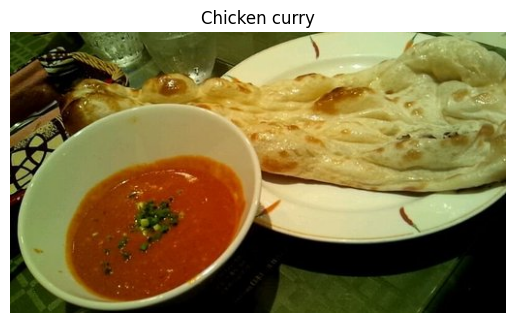

In [12]:
_helper.evaluation.view_random_image("./resources/10_food_classes_10_percent/train/", CLASS_NAMES[0])

# Model Experiments

## Model 1:Base Line Model
- Random 10% of Training data only
- Feature Extractor: EfficientNetB0

### Model 1:1

In [4]:
try:
  # Feature Extraction
  enb0 = tf.keras.applications.EfficientNetB0(include_top = False)

  enb0.trainable = False

  input = Input(shape = (224, 224, 3), name = "input_layer")

  # Resnet50v2 Need extra layer which is normalization
  # x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

  x = enb0(input)
  x = GlobalAveragePooling2D(name = "GAP2D_layer")(x)
  output = Dense(10, activation = "softmax", name = "output_layer")(x)

  enb0_m1_a = Model(input, output, name = "ENB0_Model_1")

  enb0_m1_a.compile(
    loss = "categorical_crossentropy",
    optimizer = Adam(),
    metrics = ["CategoricalAccuracy", "Precision"]
  )

  enb0_m1_a_h = enb0_m1_a.fit(train_data_10p,
                          epochs = 15,
                          steps_per_epoch = len(train_data_10p),
                          validation_data = test_data_10p,
                          validation_steps = int(0.25 * len(test_data_10p)),
                          callbacks = [_helper.callbacks.tensorboard_callback("./log/TLFT/m1",
                                                                              "A")])
  _helper.notifications.model_callback_notification()
except Exception as e:
  print(f"Error: {e}")
  _helper.notifications.error()

Saving TensorBoard Log Files to: ./log/TLFT/m1/A/2022_08_23 - 20_24_log
Epoch 1/15
24/24 [==============================] - 91s 3s/step - loss: 1.8837 - categorical_accuracy: 0.4347 - precision: 1.0000 - val_loss: 1.2792 - val_categorical_accuracy: 0.7763 - val_precision: 0.9848
Epoch 2/15
24/24 [==============================] - 58s 2s/step - loss: 1.0838 - categorical_accuracy: 0.7920 - precision: 0.9589 - val_loss: 0.8421 - val_categorical_accuracy: 0.8339 - val_precision: 0.9706
Epoch 3/15
24/24 [==============================] - 56s 2s/step - loss: 0.7804 - categorical_accuracy: 0.8333 - precision: 0.9559 - val_loss: 0.6557 - val_categorical_accuracy: 0.8766 - val_precision: 0.9608
Epoch 4/15
24/24 [==============================] - 56s 2s/step - loss: 0.6382 - categorical_accuracy: 0.8587 - precision: 0.9632 - val_loss: 0.5855 - val_categorical_accuracy: 0.8635 - val_precision: 0.9557
Epoch 5/15
24/24 [==============================] - 52s 2s/step - loss: 0.5408 - categorical_acc

Model is saved to ./saved_files/TL_FT/m1/A/Model 1.h5 and ./saved_files/TL_FT/m1/A/Model 1_diagram.png
History is saved to ./saved_files/TL_FT/m1/A/Model 1_history.json


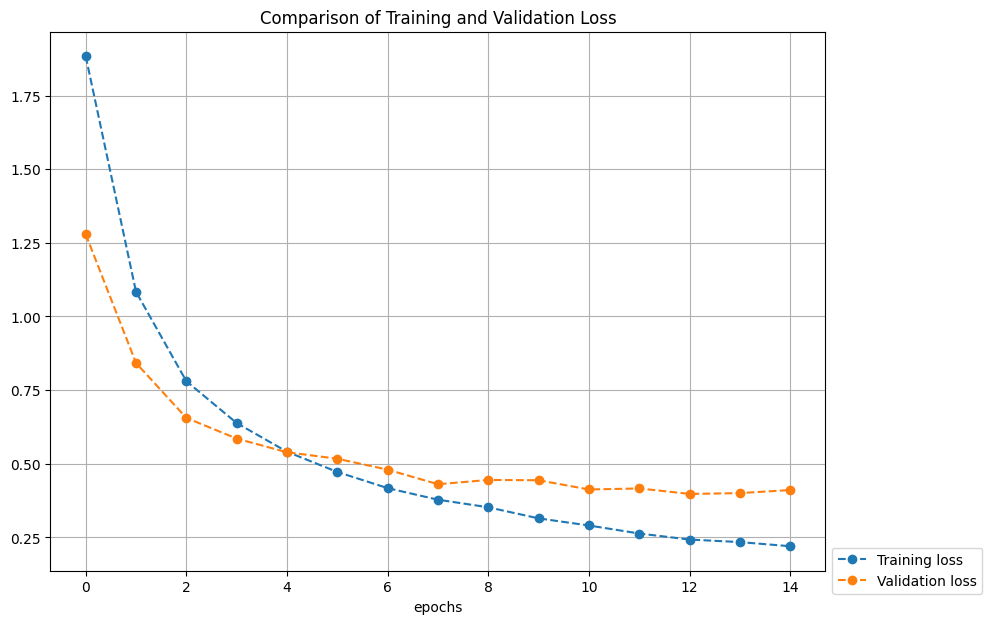

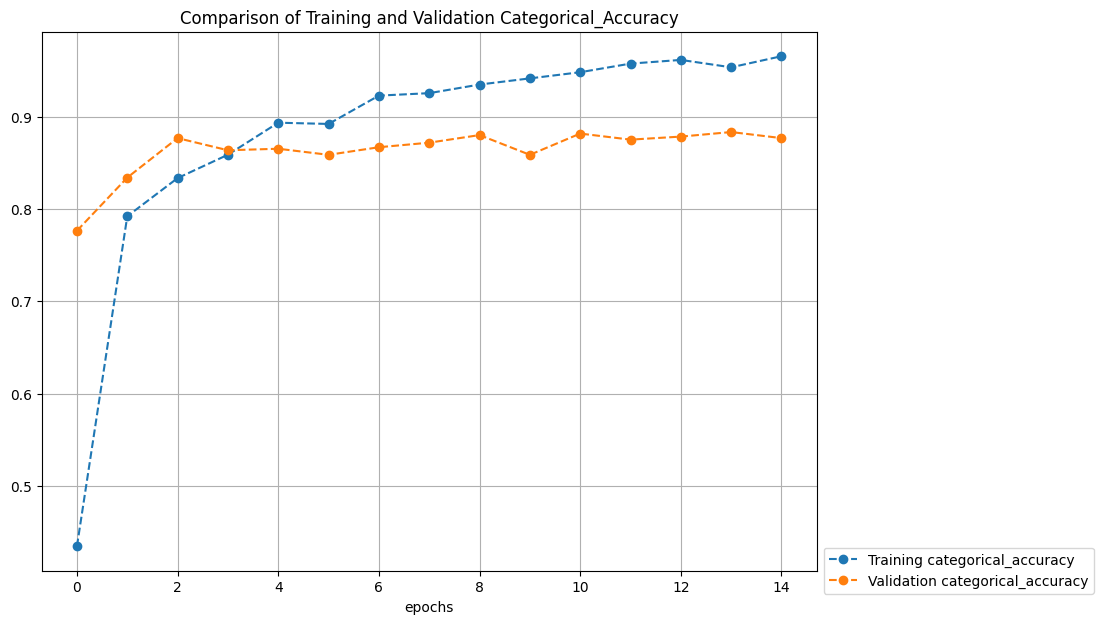

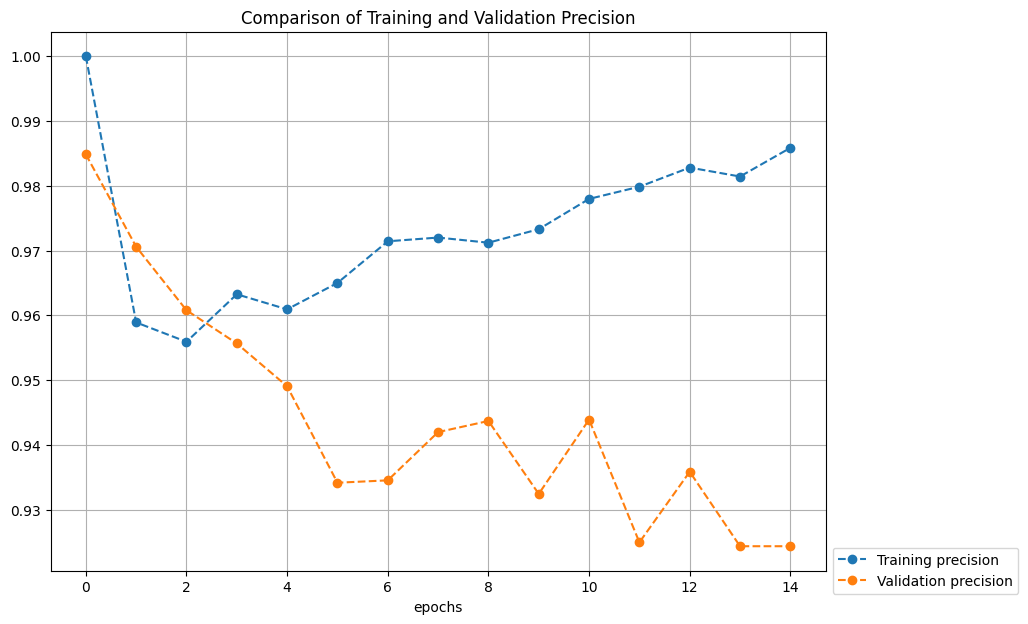

In [5]:
try:
  _helper.evaluation.history_plot(history = enb0_m1_a_h,
                                  specification = "comp_loss",
                                  grid = True, 
                                  plot_style = "o--",
                                  save_path = "./saved_files/TL_FT/m1")

  _helper.evaluation.history_plot(history = enb0_m1_a_h,
                                  specification = "comp_categorical_accuracy",
                                  grid = True, 
                                  plot_style = "o--",
                                  save_path = "./saved_files/TL_FT/m1")

  _helper.evaluation.history_plot(history = enb0_m1_a_h,
                                  specification = "comp_precision",
                                  grid = True, 
                                  plot_style = "o--",
                                  save_path = "./saved_files/TL_FT/m1")

  _helper.save_load.save(model = enb0_m1_a,
                        history = enb0_m1_a_h,
                        path = "./saved_files/TL_FT/m1/A",
                        name = "Model 1")
except Exception as e:
  print(f"Error {e}")
  _helper.notifications.error()

### Model 1 Custom

In [6]:
try:
  # Feature Extraction
  enb0 = tf.keras.applications.EfficientNetB0(include_top = False)

  enb0.trainable = False

  input = Input(shape = (224, 224, 3), name = "input_layer")

  # Resnet50v2 Need extra layer which is normalization
  # x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

  x = enb0(input)
  x = GlobalAveragePooling2D(name = "GAP2D_layer")(x)
  output = Dense(10, activation = "softmax", name = "output_layer")(x)

  enb0_m1_b = Model(input, output, name = "ENB0_Model_1")

  enb0_m1_b.compile(
    loss = "categorical_crossentropy",
    optimizer = Adam(),
    metrics = ["CategoricalAccuracy", "Precision"]
  )

  enb0_m1_b_h = enb0_m1_b.fit(train_data_10p,
                          epochs = 15,
                          steps_per_epoch = len(train_data_10p),
                          validation_data = test_data_10p,
                          validation_steps = len(test_data_10p),
                          callbacks = [_helper.callbacks.tensorboard_callback("./log/TLFT/m1", 
                                                                              "B")])
  _helper.notifications.model_callback_notification()
except Exception as e:
  print(f"Error: {e}")
  _helper.notifications.error()

Saving TensorBoard Log Files to: ./log/TLFT/m1/B/2022_08_23 - 20_38_log
Epoch 1/15
24/24 [==============================] - 153s 6s/step - loss: 1.8676 - categorical_accuracy: 0.4227 - precision: 0.9231 - val_loss: 1.2845 - val_categorical_accuracy: 0.7520 - val_precision: 0.9819
Epoch 2/15
24/24 [==============================] - 121s 5s/step - loss: 1.0889 - categorical_accuracy: 0.7787 - precision: 0.9652 - val_loss: 0.8618 - val_categorical_accuracy: 0.8232 - val_precision: 0.9762
Epoch 3/15
24/24 [==============================] - 118s 5s/step - loss: 0.7982 - categorical_accuracy: 0.8307 - precision: 0.9583 - val_loss: 0.6919 - val_categorical_accuracy: 0.8448 - val_precision: 0.9584
Epoch 4/15
24/24 [==============================] - 122s 5s/step - loss: 0.6474 - categorical_accuracy: 0.8533 - precision: 0.9496 - val_loss: 0.6080 - val_categorical_accuracy: 0.8560 - val_precision: 0.9544
Epoch 5/15
24/24 [==============================] - 124s 5s/step - loss: 0.5469 - categorica

In [8]:
enb0_m1_b.evaluate(test_data_10p)

79/79 [==============================] - 95s 1s/step - loss: 0.4073 - categorical_accuracy: 0.8784 - precision: 0.9270


[0.40731868147850037, 0.8784000277519226, 0.9269941449165344]

In [9]:
for no, layer in enumerate(enb0.layers):
  print(no, layer.name)

0 input_2
1 rescaling_1
2 normalization_1
3 tf.math.truediv_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_ac

Model is saved to ./saved_files/TL_FT/m1/B/Model 1.h5 and ./saved_files/TL_FT/m1/B/Model 1_diagram.png
History is saved to ./saved_files/TL_FT/m1/B/Model 1_history.json


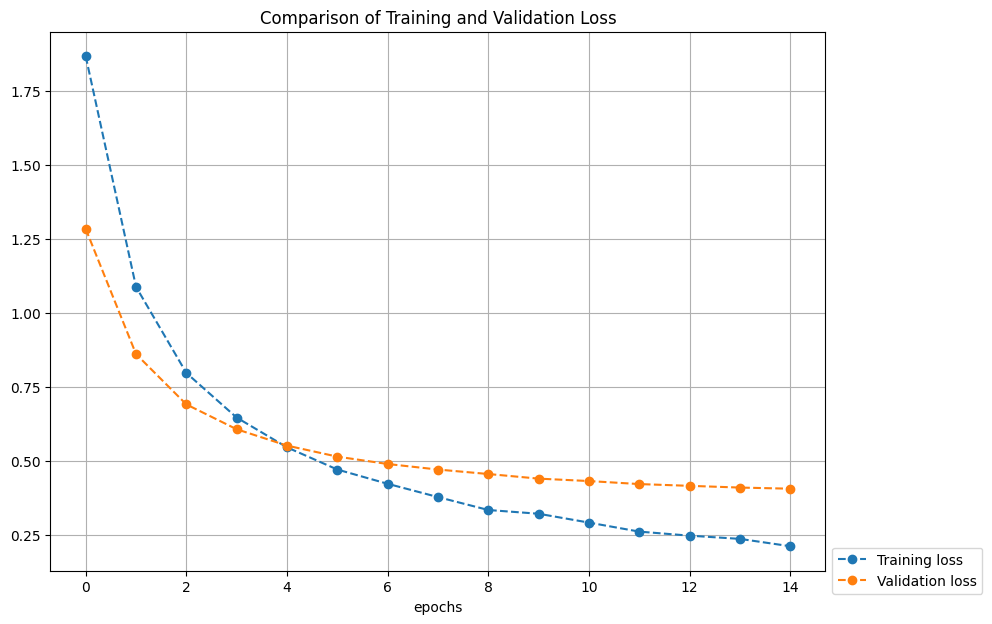

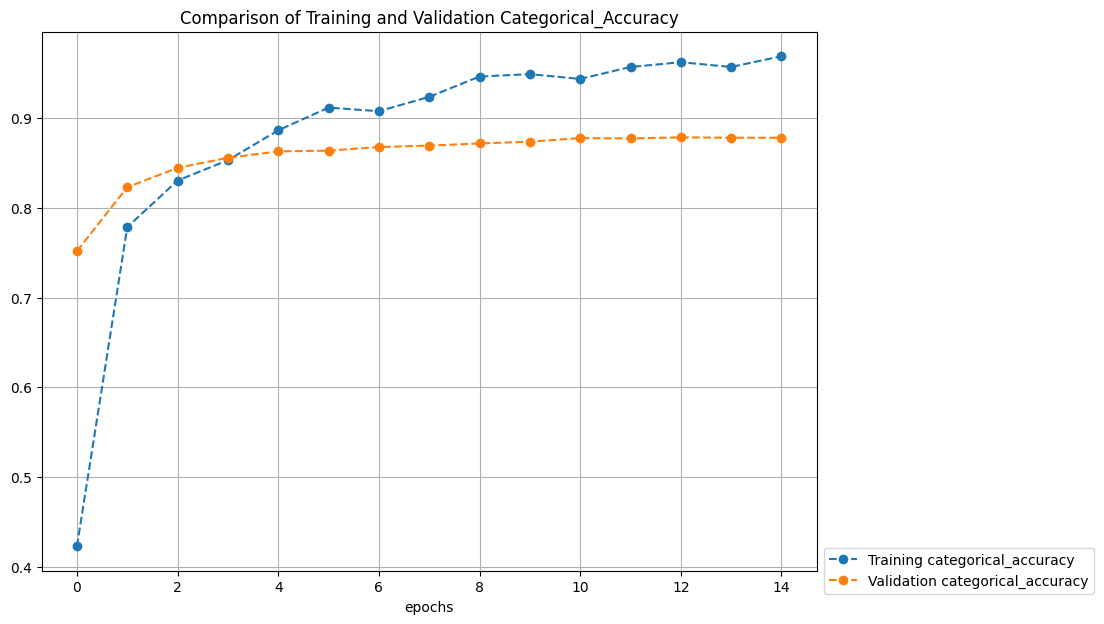

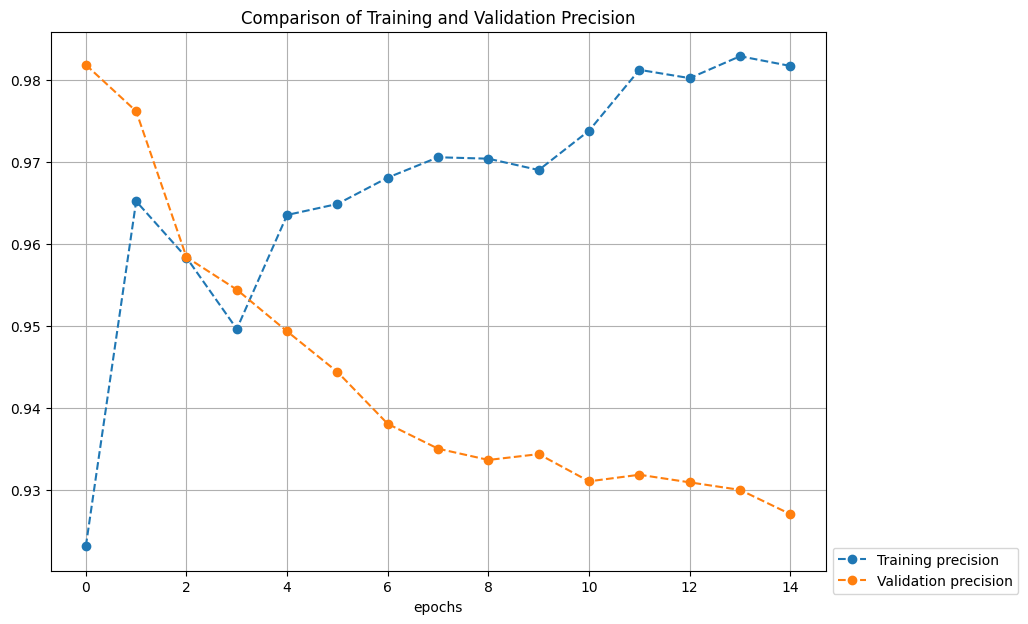

In [10]:
try:
  _helper.evaluation.history_plot(history = enb0_m1_b_h,
                                  specification = "comp_loss",
                                  grid = True, 
                                  plot_style = "o--",
                                  save_path = "./saved_files/TL_FT/m1/B")

  _helper.evaluation.history_plot(history = enb0_m1_b_h,
                                  specification = "comp_categorical_accuracy",
                                  grid = True,
                                  plot_style = "o--",
                                  save_path = "./saved_files/TL_FT/m1/B")

  _helper.evaluation.history_plot(history = enb0_m1_b_h,
                                  specification = "comp_precision",
                                  grid = True, 
                                  plot_style = "o--",
                                  save_path = "./saved_files/TL_FT/m1/B")

  _helper.save_load.save(model = enb0_m1_b,
                        history = enb0_m1_b_h,
                        path = "./saved_files/TL_FT/m1/B",
                        name = "Model 1")
except Exception as e:
  print(f"Error: {e}")
  _helper.notifications.error()

## Getting a feature vector from trained model
Demonstrate The global Average Pooling 2D layer

In [ ]:
input_shape = 1, 4, 4, 3

tf.random.set_seed(14)
input_tensor = tf.random.normal(input_shape)

gap_tensor = GlobalAveragePooling2D()(input_tensor)

print("Shape Comparison:\n" +
      f"Input tensor {input_tensor.shape}\n" +
      f"GAP tensor {gap_tensor.shape}")

In [ ]:
reduce_tensor = tf.reduce_mean(input_tensor, axis = [1, 2])

print("Comparison:\n" +
      f"Gap tensor: {gap_tensor}\n"
      f"Reduce tensor: {reduce_tensor}")

## Model 2
- Random 1% of Training data only
- Augmented Data
- Feature Extractor: EfficientNetB0

In [ ]:
_helper.data_preparations.zip_processing(url = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip",
                                         zip_name = "10_food_classes_1_percent")

In [13]:
train_data_1p, test_data_1p, CLASS_NAMES = _helper.data_preparations.train_test_dir_setter("./resources/10_food_classes_1_percent/",
                                                                                     CLASS_MODE = "categorical")

Test Data: 
Found 2500 files belonging to 10 classes.
Train Data: 
Found 70 files belonging to 10 classes.
Class Names: ['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']


### Model 2 1:1

In [20]:
data_augmentation = Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.2),
  RandomZoom(0.2),
  RandomHeight(0.2),
  RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

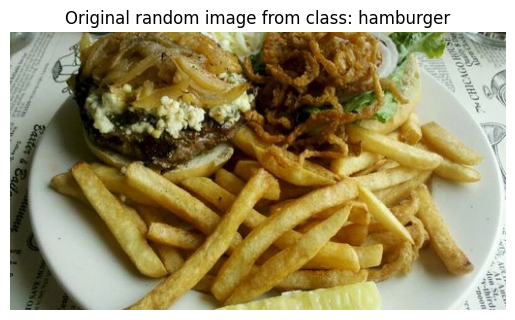

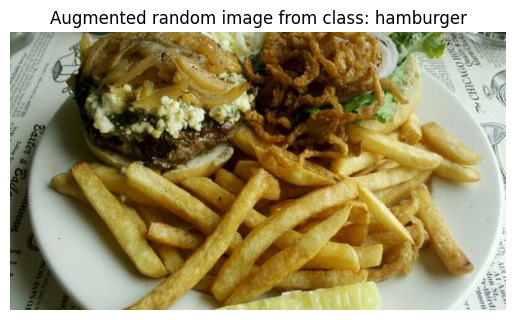

In [22]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(CLASS_NAMES) # choose a random class
target_dir = f"./resources/10_food_classes_1_percent/train/{target_class}" # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [29]:
try:
  INPUT_SHAPE = (224, 224, 3,)
  enb0 = tf.keras.applications.EfficientNetB0(include_top = False)
  enb0.trainable = False

  input = Input(shape = INPUT_SHAPE,
                name = "Input_Layer")

  x = data_augmentation(input)
  x = enb0(x, training = False)
  x = GlobalAveragePooling2D(name = "GAP_layer")(x)
  outputs = Dense(10, activation = "softmax", name = "output_layer")(x)

  enb0_m2_a = Model(input, outputs, name = "ENB0_Model_2")

  enb0_m2_a.compile(
    loss = "categorical_crossentropy",
    optimizer = Adam(),
    metrics = ["CategoricalAccuracy", "Precision"]
  )

  enb0_m2_a_h = enb0_m2_a.fit(train_data_1p,
                          epochs = 15,
                          steps_per_epoch = len(train_data_1p),
                          validation_data = test_data_1p,
                          validation_steps = int(0.5 * len(test_data_1p)),
                          callbacks = [_helper.callbacks.tensorboard_callback("./log/TLFT/m2",
                                                                              "A")])

  _helper.notifications.model_callback_notification()
except Exception as e:
  print(f"Error: {e}")
  _helper.notifications.error()

Saving TensorBoard Log Files to: ./log/TLFT/m2/A/2022_08_23 - 22_46_log
Epoch 1/15
79/79 [==============================] - 135s 1s/step - loss: 1.3575 - categorical_accuracy: 0.6176 - precision: 0.9389 - val_loss: 0.7718 - val_categorical_accuracy: 0.7812 - val_precision: 0.9500
Epoch 2/15
79/79 [==============================] - 111s 1s/step - loss: 0.6959 - categorical_accuracy: 0.8184 - precision: 0.9367 - val_loss: 0.6412 - val_categorical_accuracy: 0.7812 - val_precision: 0.8148
Epoch 3/15
79/79 [==============================] - 104s 1s/step - loss: 0.5532 - categorical_accuracy: 0.8488 - precision: 0.9345 - val_loss: 0.6027 - val_categorical_accuracy: 0.7812 - val_precision: 0.8571
Epoch 4/15
79/79 [==============================] - 110s 1s/step - loss: 0.4717 - categorical_accuracy: 0.8668 - precision: 0.9311 - val_loss: 0.4079 - val_categorical_accuracy: 0.8750 - val_precision: 0.8966
Epoch 5/15
79/79 [==============================] - 109s 1s/step - loss: 0.4221 - categorica

Model is saved to ./saved_files/TL_FT/m2/A/Model 2.h5 and ./saved_files/TL_FT/m2/A/Model 2_diagram.png
History is saved to ./saved_files/TL_FT/m2/A/Model 2_history.json


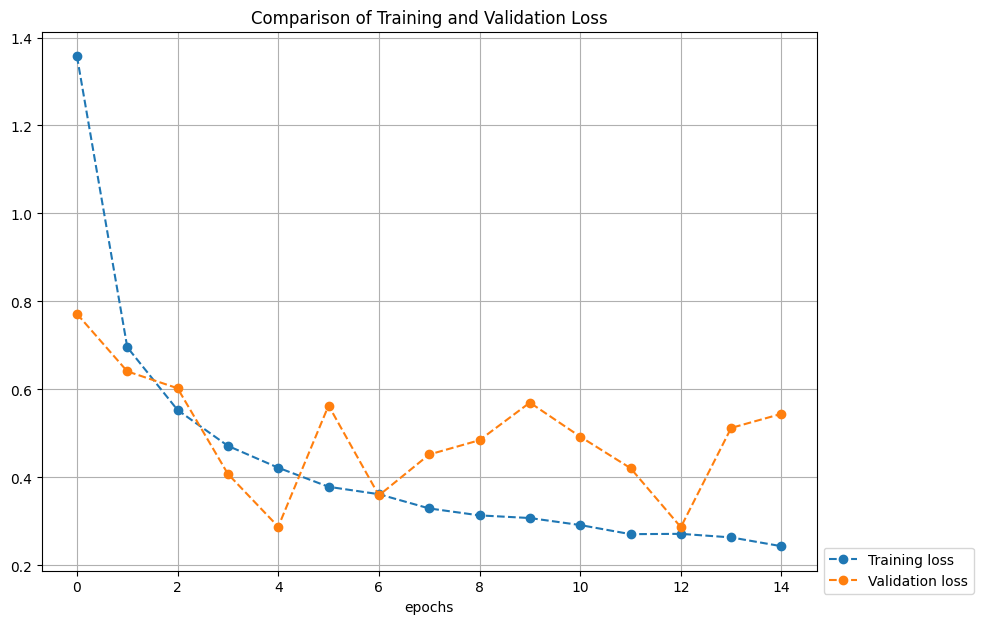

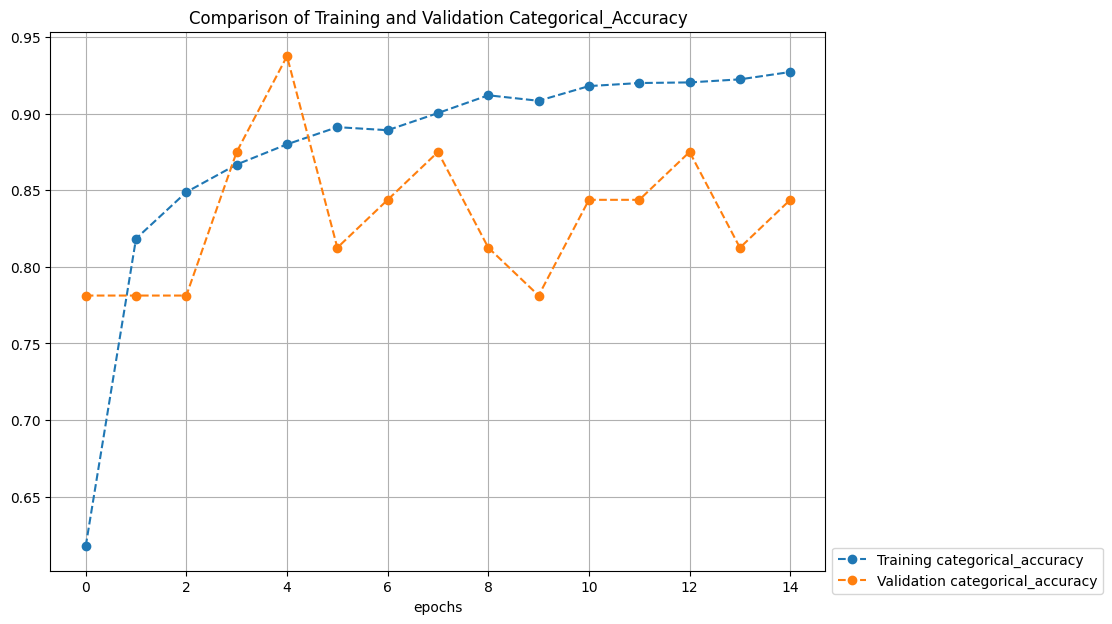

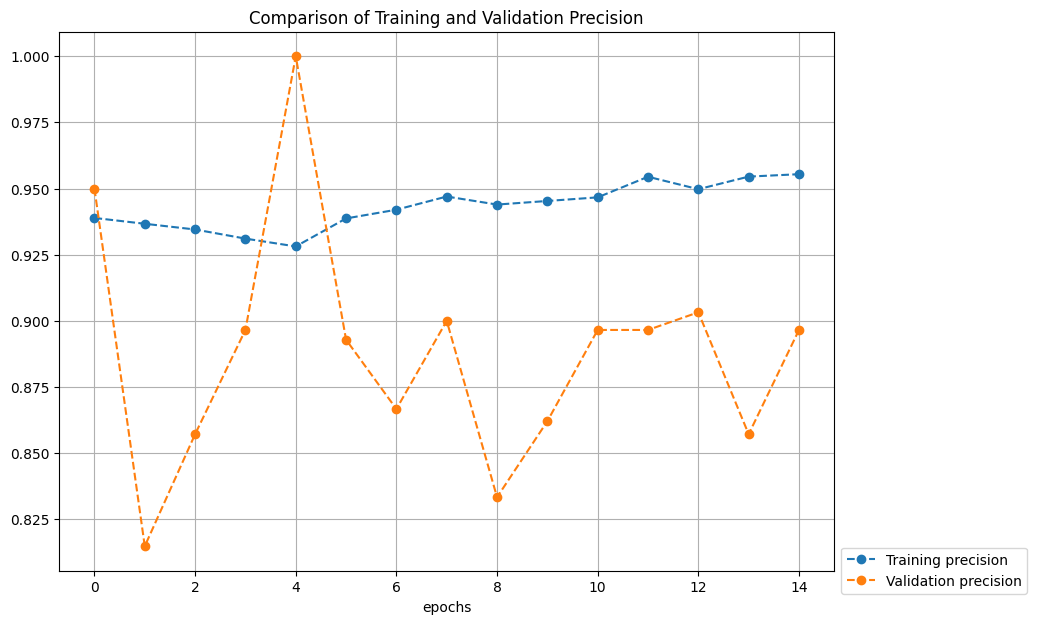

In [30]:
try:
  _helper.evaluation.history_plot(enb0_m2_a_h,                                
                                  specification = "comp_loss",
                                  grid = True, 
                                  plot_style = "o--",
                                  save_path = "./saved_files/TL_FT/m2/A")

  _helper.evaluation.history_plot(enb0_m2_a_h,                                
                                  specification = "comp_categorical_accuracy",
                                  grid = True, 
                                  plot_style = "o--",
                                  save_path = "./saved_files/TL_FT/m2/A")

  _helper.evaluation.history_plot(enb0_m2_a_h,                                
                                  specification = "comp_precision",
                                  grid = True, 
                                  plot_style = "o--",
                                  save_path = "./saved_files/TL_FT/m2/A")

  _helper.save_load.save(model = enb0_m2_a,
                        history = enb0_m2_a_h,
                        path = "./saved_files/TL_FT/m2/A",
                        name = "Model 2")
except Exception as e:
  print(f"Error: {e}")
  _helper.notifications.error()

### Model 2 Custom

Adding Data Augmentation Layer

In [31]:
data_augmented = Sequential([
  RandomFlip("horizontal"),  RandomZoom(0.5),
  RandomHeight(0.5), RandomWidth(0.5), RandomRotation(0.5),
], name = "Data_Augmentation")

Test Data Augmentation

(-0.5, 511.5, 246.5, -0.5)

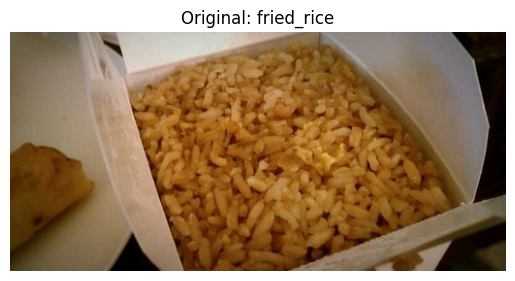

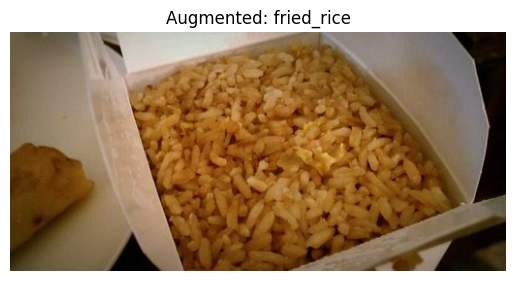

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, random

target_class = random.choice(CLASS_NAMES)
target_dir = f"./resources/10_food_classes_1_percent/train/{target_class}"

random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

img = mpimg.imread(random_image_path)
plt.title(f"Original: {target_class}")
plt.axis(False)
plt.imshow(img)

a_img = data_augmented(tf.expand_dims(img, axis = 0))
plt.figure()
plt.imshow(tf.squeeze(a_img)/255.)
plt.title(f"Augmented: {target_class}")
plt.axis(False)

Model Coding

In [32]:
try:
  INPUT_SHAPE = (224, 224, 3,)
  enb0 = tf.keras.applications.EfficientNetB0(include_top = False)
  enb0.trainable = False
  
  input = Input(shape = INPUT_SHAPE,
                name = "Input_Layer")

  x = data_augmented(input)
  x = enb0(x, training = False)
  x = GlobalAveragePooling2D(name = "GAP_layer")(x)
  outputs = Dense(10, activation = "softmax", name = "output_layer")(x)

  enb0_m2_b = Model(input, outputs, name = "ENB0_Model_2")

  enb0_m2_b.compile(
    loss = "categorical_crossentropy",
    optimizer = Adam(),
    metrics = ["CategoricalAccuracy", "Precision"]
  )

  enb0_m2_b_h = enb0_m2_b.fit(train_data_1p,
                          epochs = 15,
                          steps_per_epoch = len(train_data_1p),
                          validation_data = test_data_1p,
                          validation_steps = len(test_data_1p),
                          callbacks = [_helper.callbacks.tensorboard_callback("./log/TLFT/m2",
                                                                              "B")])

  _helper.notifications.model_callback_notification()
except Exception as e:
  print(f"Error: {e}")
  _helper.notifications.error()

Saving TensorBoard Log Files to: ./log/TLFT/m2/B/2022_08_23 - 23_20_log
Epoch 1/15
79/79 [==============================] - 142s 2s/step - loss: 1.5864 - categorical_accuracy: 0.5148 - precision: 0.9115 - val_loss: 0.8460 - val_categorical_accuracy: 0.7714 - val_precision: 0.9444
Epoch 2/15
79/79 [==============================] - 110s 1s/step - loss: 0.9792 - categorical_accuracy: 0.7204 - precision: 0.9072 - val_loss: 0.6368 - val_categorical_accuracy: 0.8286 - val_precision: 0.9245
Epoch 3/15
79/79 [==============================] - 104s 1s/step - loss: 0.8534 - categorical_accuracy: 0.7444 - precision: 0.8828 - val_loss: 0.5668 - val_categorical_accuracy: 0.8429 - val_precision: 0.9107
Epoch 4/15
79/79 [==============================] - 113s 1s/step - loss: 0.7553 - categorical_accuracy: 0.7772 - precision: 0.9037 - val_loss: 0.5284 - val_categorical_accuracy: 0.8286 - val_precision: 0.9310
Epoch 5/15
79/79 [==============================] - 120s 2s/step - loss: 0.7071 - categorica

Model is saved to ./saved_files/TL_FT/m2/B/Model 2.h5 and ./saved_files/TL_FT/m2/B/Model 2_diagram.png
History is saved to ./saved_files/TL_FT/m2/B/Model 2_history.json


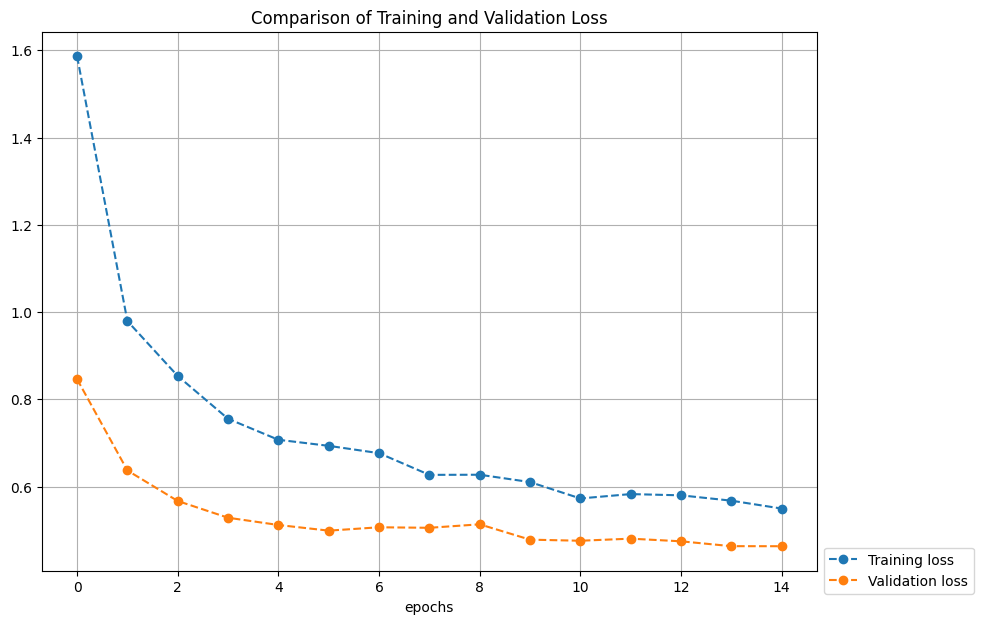

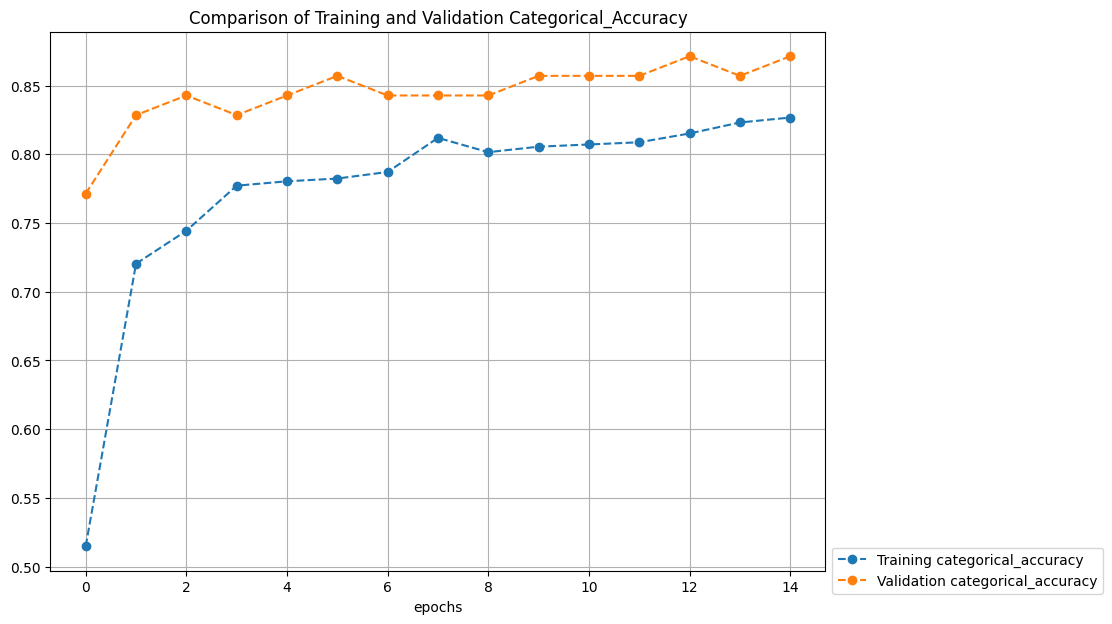

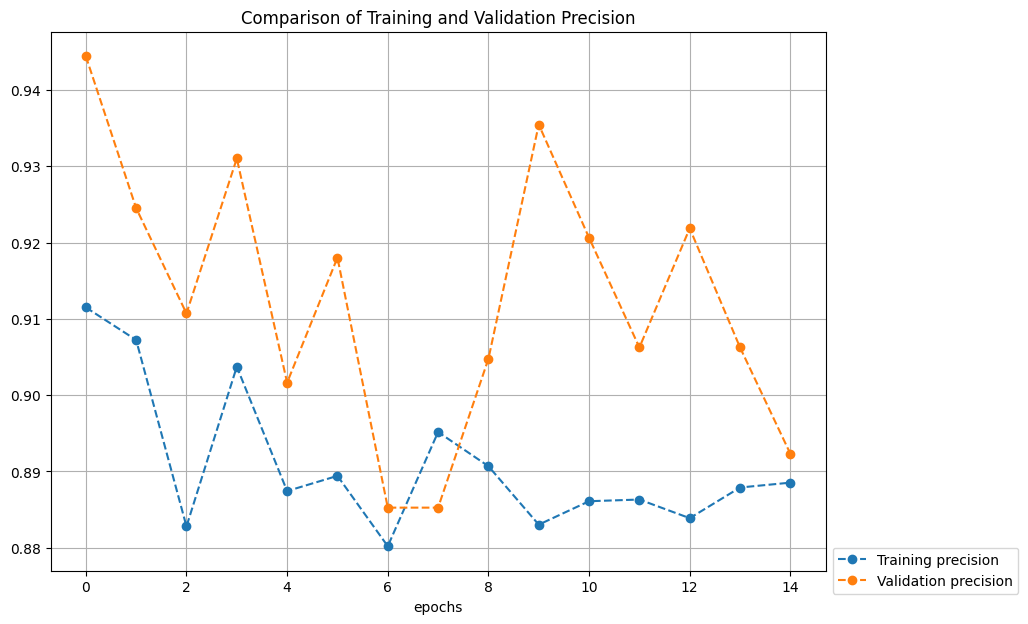

In [33]:
try:
  _helper.evaluation.history_plot(enb0_m2_b_h,                                
                                  specification = "comp_loss",
                                  grid = True, 
                                  plot_style = "o--",
                                  save_path = "./saved_files/TL_FT/m2/B")

  _helper.evaluation.history_plot(enb0_m2_b_h,                                
                                  specification = "comp_categorical_accuracy",
                                  grid = True, 
                                  plot_style = "o--",
                                  save_path = "./saved_files/TL_FT/m2/B")

  _helper.evaluation.history_plot(enb0_m2_b_h,                                
                                  specification = "comp_precision",
                                  grid = True, 
                                  plot_style = "o--",
                                  save_path = "./saved_files/TL_FT/m2/B")

  _helper.save_load.save(model = enb0_m2_b,
                        history = enb0_m2_b_h,
                        path = "./saved_files/TL_FT/m2/B",
                        name = "Model 2")
except Exception as e:
  print(f"Error: {e}")
  _helper.notifications.error()

## Model 3
- Random 10% of Training data only
- Augmented Data
- Feature Extractor: EfficientNetB0

Data Preperations

In [3]:
train_data_10p, test_data_10p, CLASS_NAME = _helper.data_preparations.train_test_dir_setter(dir = "./resources/10_food_classes_10_percent", CLASS_MODE = "categorical",)

Test Data: 
Found 2500 files belonging to 10 classes.
Train Data: 
Found 750 files belonging to 10 classes.
Class Names: ['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']


### Model 3 1:1

In [4]:
try:
  checkpoint, ckpt_dir = _helper.callbacks.checkpoint_callback("./saved_files/TL_FT/m3", "model_3",
                                                              swo = True, sbo = True)

  # Build data augmentation layer
  data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomHeight(0.2),
    RandomWidth(0.2),
    RandomZoom(0.2),
    RandomRotation(0.2),
    # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet                 
  ], name="data_augmentation")

  # Setup the input shape to our model
  input_shape = (224, 224, 3)

  # Create a frozen base model
  base_model = tf.keras.applications.EfficientNetB0(include_top=False)
  base_model.trainable = False

  # Create input and output layers
  inputs = Input(shape=input_shape, name="input_layer") # create input layer
  x = data_augmentation(inputs) # augment our training images
  x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
  x = GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
  outputs = Dense(10, activation="softmax", name="output_layer")(x)
  enb0_m3_a = tf.keras.Model(inputs, outputs)

  # Compile
  enb0_m3_a.compile(loss="categorical_crossentropy",
                optimizer=Adam(lr=0.001), # use Adam optimizer with base learning rate
                metrics=["CategoricalAccuracy", "Precision"])

  enb0_m3_a_h = enb0_m3_a.fit(train_data_10p,
                          epochs = 15,
                          steps_per_epoch = len(train_data_10p),
                          validation_data = test_data_10p,
                          validation_steps = int(0.25 * len(test_data_10p)),
                          callbacks = [_helper.callbacks.tensorboard_callback("./log/TLFT/m3",
                                                                              "A"),
                                      checkpoint])

  _helper.notifications.model_callback_notification()
except Exception as e:
  print(f"Error: {e}")
  _helper.notifications.error()

d:\Codes\TensorFlow\Zero-to-Mastery\z2m\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Saving TensorBoard Log Files to: ./log/TLFT/m3/A/2022_08_24 - 10_54_log
Epoch 1/15
79/79 [==============================] - 154s 2s/step - loss: 1.3340 - categorical_accuracy: 0.6376 - precision: 0.9392 - val_loss: 0.7964 - val_categorical_accuracy: 0.8021 - val_precision: 0.9262
Epoch 2/15
79/79 [==============================] - 123s 2s/step - loss: 0.7009 - categorical_accuracy: 0.8132 - precision: 0.9405 - val_loss: 0.7465 - val_categorical_accuracy: 0.7865 - val_precision: 0.8936
Epoch 3/15
79/79 [==============================] - 129s 2s/step - loss: 0.5591 - categorical_accuracy: 0.8420 - precision: 0.9279 - val_loss: 0.5873 - val_categorical_accuracy: 0.8438 - val_precision: 0.9286
Epoch 4/15
79/79 [==============================] - 127s 2s/step - loss: 0.4844 - categorical_accuracy: 0.8640 - precision: 0.9250 - val_loss: 0.5345 - val_categorical_accuracy: 0.8646 - val_precision: 0.9152
Epoch 5/15
79/79 [==============================] - 120s 2s/step - loss: 0.4365 - categorica

Model is saved to ./saved_files/TL_FT/m3/A/Model_2022_08_24 - 11.h5 and ./saved_files/TL_FT/m3/A/Model_diagram.png
History is saved to ./saved_files/TL_FT/m3/A/Model_2022_08_24 - 11_history.json


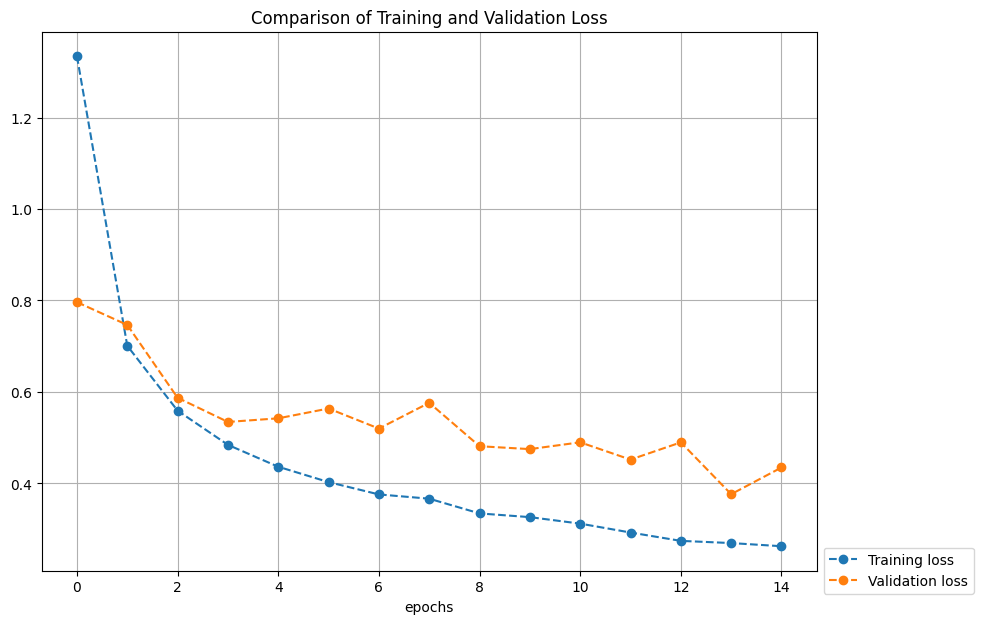

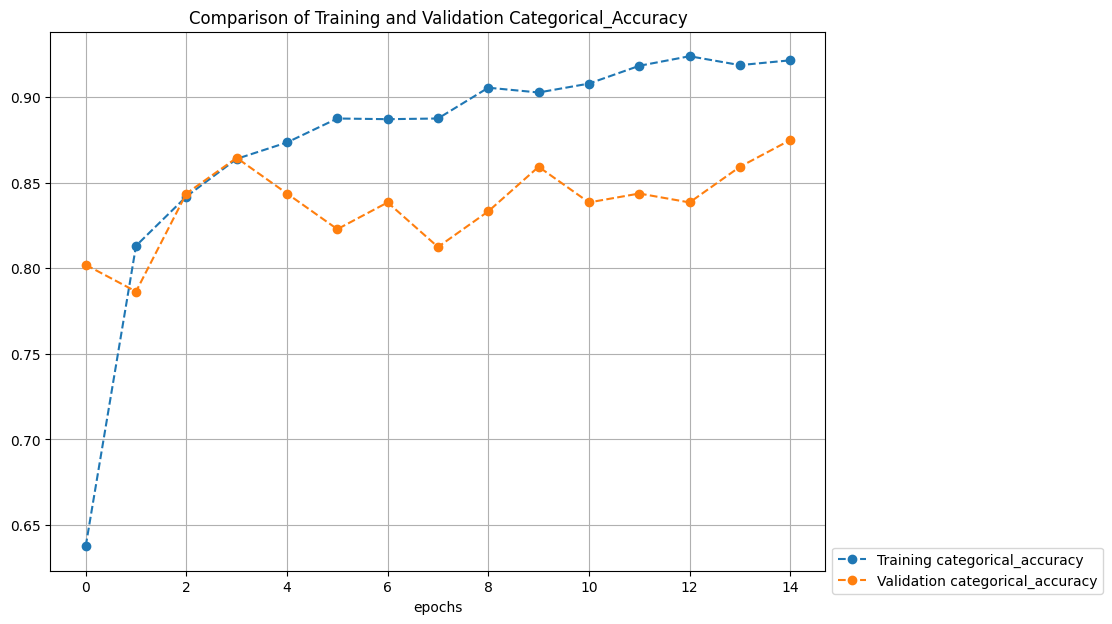

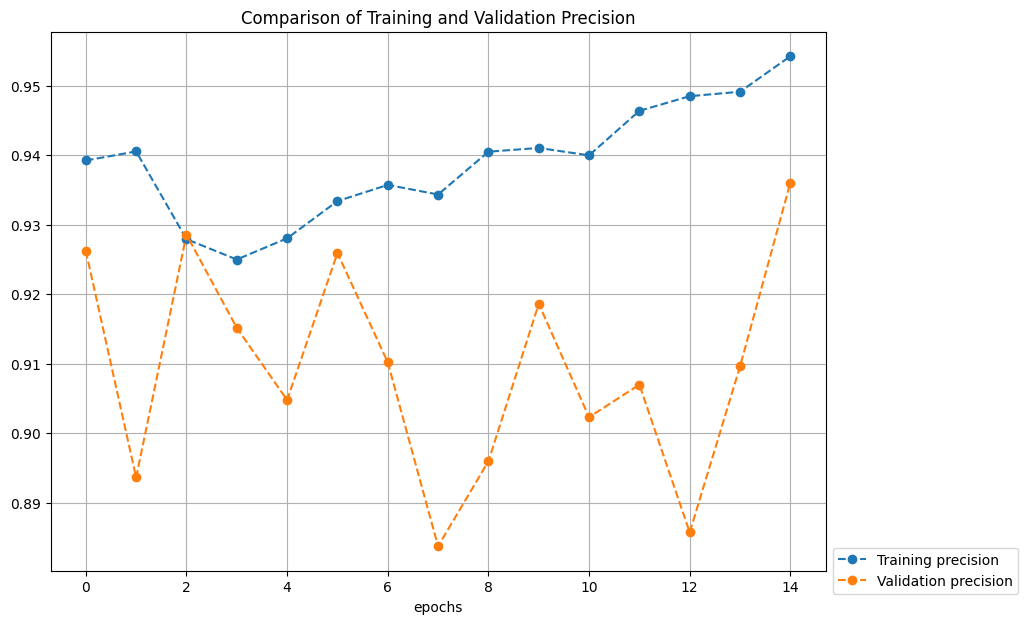

In [5]:
try:
  _helper.evaluation.history_plot(enb0_m3_a_h,
                                  specification = "comp_loss",
                                  grid = True,
                                  plot_style = "o--",
                                  save_path = "./saved_files/TL_FT/m3/A")

  _helper.evaluation.history_plot(enb0_m3_a_h,
                                  specification = "comp_categorical_accuracy",
                                  grid = True,
                                  plot_style = "o--",
                                  save_path = "./saved_files/TL_FT/m3/A")

  _helper.evaluation.history_plot(enb0_m3_a_h,
                                  specification = "comp_precision",
                                  grid = True,
                                  plot_style = "o--",
                                  save_path = "./saved_files/TL_FT/m3/A")

  _helper.save_load.save(model = enb0_m3_a, history = enb0_m3_a_h,
                        path = "./saved_files/TL_FT/m3/A")
except Exception as e:
  print(f"Error: {e}")
  _helper.notifications.error()

### Model 3 Custom

Augmentation initializer

In [6]:
data_augmented = Sequential([
  RandomFlip(),
  RandomZoom(.5),
  RandomRotation(0.5),
  RandomHeight(.5),
  RandomWidth(.5),
])

Checkpoint initialization

In [7]:
checkpoint, ckpt_dir = _helper.callbacks.checkpoint_callback("./saved_files/TL_FT/m3", "model_3",
                                                             swo = True, sbo = True)

Model

In [8]:
try:
  enb0 = tf.keras.applications.EfficientNetB0(include_top = False)
  enb0.trainable = False

  input = Input(shape = (224, 224, 3), name = "Input_Layer")

  x = data_augmented(input)
  x = enb0(x)
  x = GlobalAveragePooling2D(name = "GAP2D_Layer")(x)
  output = Dense(10, activation = "softmax", name = "Output_Layer")(x)

  enb0_m3_b = Model(input, output, name = "ENB0_Model_3")

  enb0_m3_b.compile(
    loss = "categorical_crossentropy",
    optimizer = Adam(),
    metrics = ["CategoricalAccuracy", "Precision"]
  )

  enb0_m3_b_h = enb0_m3_b.fit(train_data_10p,
                          epochs = 15,
                          steps_per_epoch = len(train_data_10p),
                          validation_data = test_data_10p,
                          validation_steps = len(test_data_10p),
                          callbacks = [_helper.callbacks.tensorboard_callback("./log/TLFT/m3",
                                                                              "B"),
                                      checkpoint])

  _helper.notifications.model_callback_notification()
except Exception as e:
  print(f"Error: {e}")
  _helper.notifications.error()

Saving TensorBoard Log Files to: ./log/TLFT/m3/B/2022_08_24 - 11_26_log
Epoch 1/15
79/79 [==============================] - 168s 2s/step - loss: 1.5527 - categorical_accuracy: 0.5228 - precision: 0.9340 - val_loss: 0.9422 - val_categorical_accuracy: 0.7453 - val_precision: 0.9339
Epoch 2/15
79/79 [==============================] - 147s 2s/step - loss: 0.9478 - categorical_accuracy: 0.7256 - precision: 0.9082 - val_loss: 0.7220 - val_categorical_accuracy: 0.7933 - val_precision: 0.9272
Epoch 3/15
79/79 [==============================] - 148s 2s/step - loss: 0.7930 - categorical_accuracy: 0.7696 - precision: 0.8999 - val_loss: 0.6510 - val_categorical_accuracy: 0.8067 - val_precision: 0.9147
Epoch 4/15
79/79 [==============================] - 143s 2s/step - loss: 0.7319 - categorical_accuracy: 0.7768 - precision: 0.8897 - val_loss: 0.6316 - val_categorical_accuracy: 0.8067 - val_precision: 0.9054
Epoch 5/15
79/79 [==============================] - 144s 2s/step - loss: 0.6862 - categorica

Evaluation of Model

Model is saved to ./saved_files/TL_FT/m3/B/Model_2022_08_24 - 12.h5 and ./saved_files/TL_FT/m3/B/Model_diagram.png
History is saved to ./saved_files/TL_FT/m3/B/Model_2022_08_24 - 12_history.json


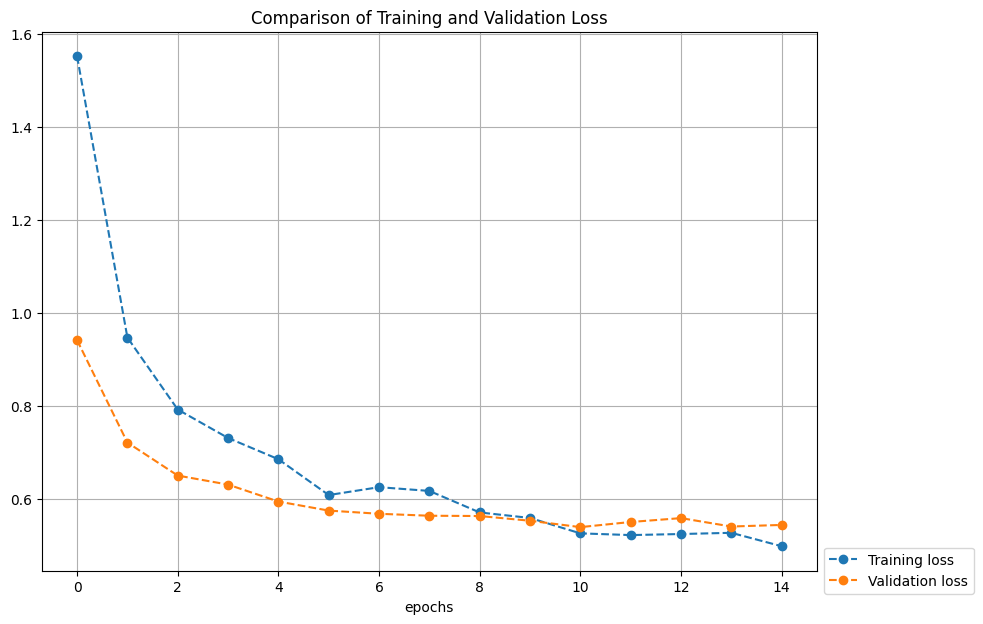

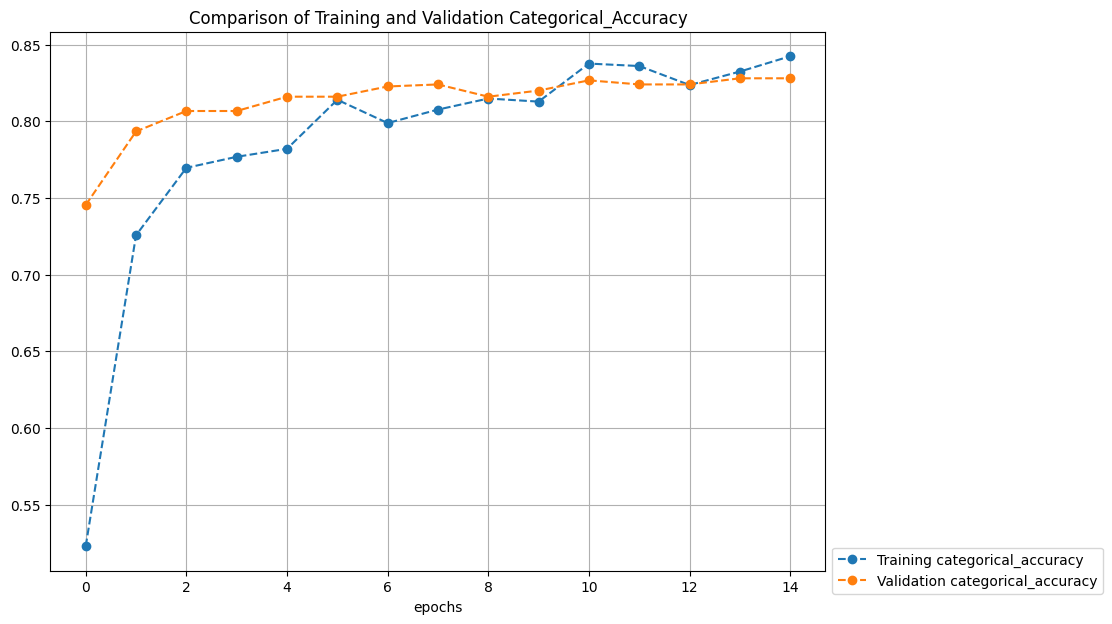

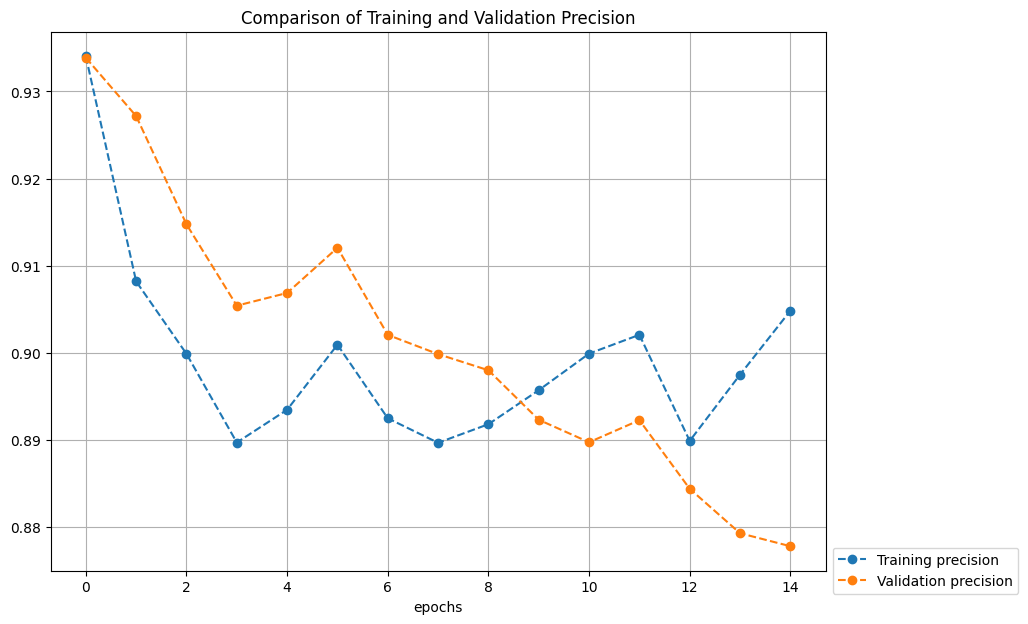

In [9]:
try:
  _helper.evaluation.history_plot(enb0_m3_b_h,
                                  specification = "comp_loss",
                                  grid = True,
                                  plot_style = "o--",
                                  save_path = "./saved_files/TL_FT/m3/B")

  _helper.evaluation.history_plot(enb0_m3_b_h,
                                  specification = "comp_categorical_accuracy",
                                  grid = True,
                                  plot_style = "o--",
                                  save_path = "./saved_files/TL_FT/m3/B")

  _helper.evaluation.history_plot(enb0_m3_b_h,
                                  specification = "comp_precision",
                                  grid = True,
                                  plot_style = "o--",
                                  save_path = "./saved_files/TL_FT/m3/B")

  _helper.save_load.save(model = enb0_m3_b, history = enb0_m3_b_h,
                        path = "./saved_files/TL_FT/m3/B")
except Exception as e:
  print(f"Error: {e}")
  _helper.notifications.error()

In [10]:
enb0_m3_b.summary()

Model: "ENB0_Model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 GAP2D_Layer (GlobalAverageP  (None, 1280)             0         
 ooling2D)                                                       
                                                                 
 Output_Layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_______________________________________

Before Checkpoint loading

In [11]:
enb0_m3_b.evaluate(test_data_10p)

24/24 [==============================] - 32s 1s/step - loss: 0.5449 - categorical_accuracy: 0.8280 - precision: 0.8778


[0.5448605418205261, 0.828000009059906, 0.8777943253517151]

In [12]:
enb0_m3_b.load_weights(ckpt_dir)

After checkpoint loading

In [13]:
enb0_m3_b.evaluate(test_data_10p)

24/24 [==============================] - 32s 1s/step - loss: 0.5401 - categorical_accuracy: 0.8267 - precision: 0.8897


[0.5401402711868286, 0.8266666531562805, 0.8897280693054199]

## Model 4: Fine Tuning
- Random 10% of Training data only
- Augmented Data
- Fine Tuning: Model 2, with top layer trained on custom data, top 10 layer will be unfrozen (Top Means Nearer to the output layer)

### Model 4

> Note: When Fine Tuning Optimizer should be lower to x10. by ULFIT paper: https://arvix.org/abs/1810.06146

#### Model 4 1:1

In [18]:
print(len(enb0_m3_a.layers[2].trainable_variables))
print(len(enb0.trainable_variables))

0
0


In [29]:
enb0.trainable = False
print(len(enb0_m3_a.layers[2].trainable_variables))
print(len(enb0.trainable_variables))

0
0


In [42]:
enb0.trainable = True

# Freeze all layers except for the
for layer in enb0.layers[:-10]:
  layer.trainable = False
  
# Recompile the model (always recompile after any adjustments to a model)
enb0_m3_a.compile(loss="categorical_crossentropy",
              optimizer=Adam(lr=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["CategoricalAccuracy", "Precision"])

d:\Codes\TensorFlow\Zero-to-Mastery\z2m\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [43]:
print(len(enb0_m3_a.layers[2].trainable_variables))
print(len(enb0.trainable_variables))
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(enb0_m3_a.layers):
  print(layer_number, layer.name, layer.trainable)


0
10
0 input_layer True
1 data_augmentation True
2 efficientnetb0 False
3 global_average_pooling_layer True
4 output_layer True


In [50]:
enb0_m4_a = enb0_m3_a
enb0_m4_a.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainabl

In [51]:
try:
  # Fine tune for another 5 epochs
  fine_tune_epochs = enb0_m3_a_h.epoch[-1] + 15

  enb0_m4_a = enb0_m3_a

  # Refit the model (same as model_2 except with more trainable layers)
  enb0_m4_a_h = enb0_m4_a.fit(train_data_10p,
                              epochs=fine_tune_epochs,
                              validation_data=test_data_10p,
                              initial_epoch=enb0_m3_a_h.epoch[-1], # start from previous last epoch
                              validation_steps=int(0.25 * len(test_data_10p)),
                              callbacks=[_helper.callbacks.tensorboard_callback("./log/TLFT/m4/",
                                                                                      "A"),
                                        checkpoint])
  _helper.notifications.model_callback_notification()
except Exception as e:
  print(f"Error: {e}")
  _helper.notifications.error()

Saving TensorBoard Log Files to: ./log/TLFT/m4//A/2022_08_24 - 15_15_log
Epoch 15/29
79/79 [==============================] - 143s 2s/step - loss: 0.2591 - categorical_accuracy: 0.9212 - precision: 0.9552 - val_loss: 0.5096 - val_categorical_accuracy: 0.8542 - val_precision: 0.8971
Epoch 16/29
79/79 [==============================] - 117s 1s/step - loss: 0.2383 - categorical_accuracy: 0.9324 - precision: 0.9558 - val_loss: 0.4404 - val_categorical_accuracy: 0.8490 - val_precision: 0.9181
Epoch 17/29
79/79 [==============================] - 120s 2s/step - loss: 0.2355 - categorical_accuracy: 0.9340 - precision: 0.9611 - val_loss: 0.4064 - val_categorical_accuracy: 0.8698 - val_precision: 0.9091
Epoch 18/29
79/79 [==============================] - 123s 2s/step - loss: 0.2560 - categorical_accuracy: 0.9216 - precision: 0.9543 - val_loss: 0.4642 - val_categorical_accuracy: 0.8698 - val_precision: 0.9143
Epoch 19/29
79/79 [==============================] - 120s 2s/step - loss: 0.2481 - cate

Model is saved to ./saved_files/TL_FT/m4/A/Model_2022_08_24 - 15.h5 and ./saved_files/TL_FT/m4/A/Model_diagram.png
History is saved to ./saved_files/TL_FT/m4/A/Model_2022_08_24 - 15_history.json


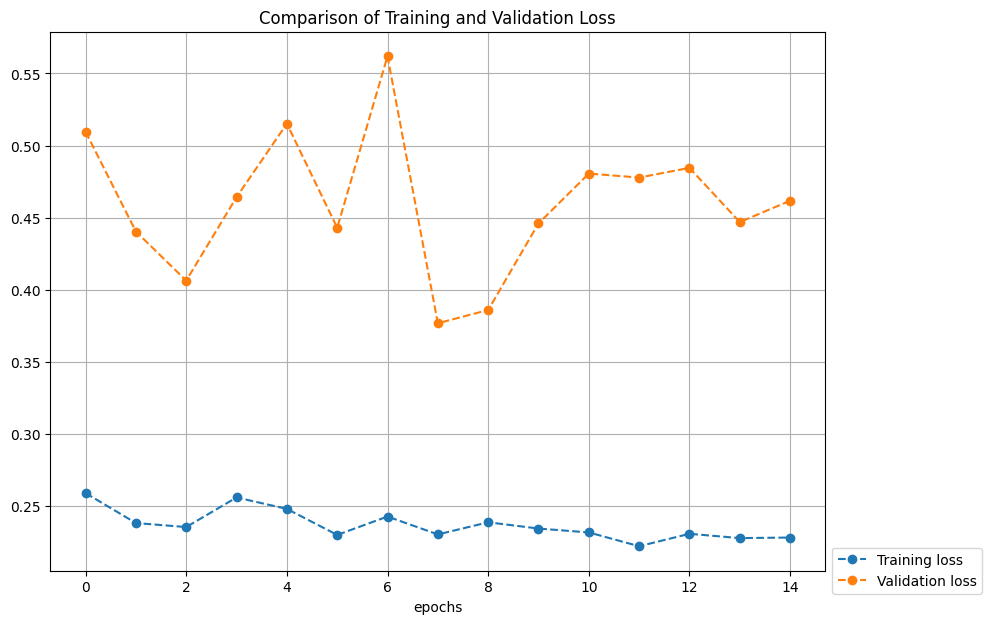

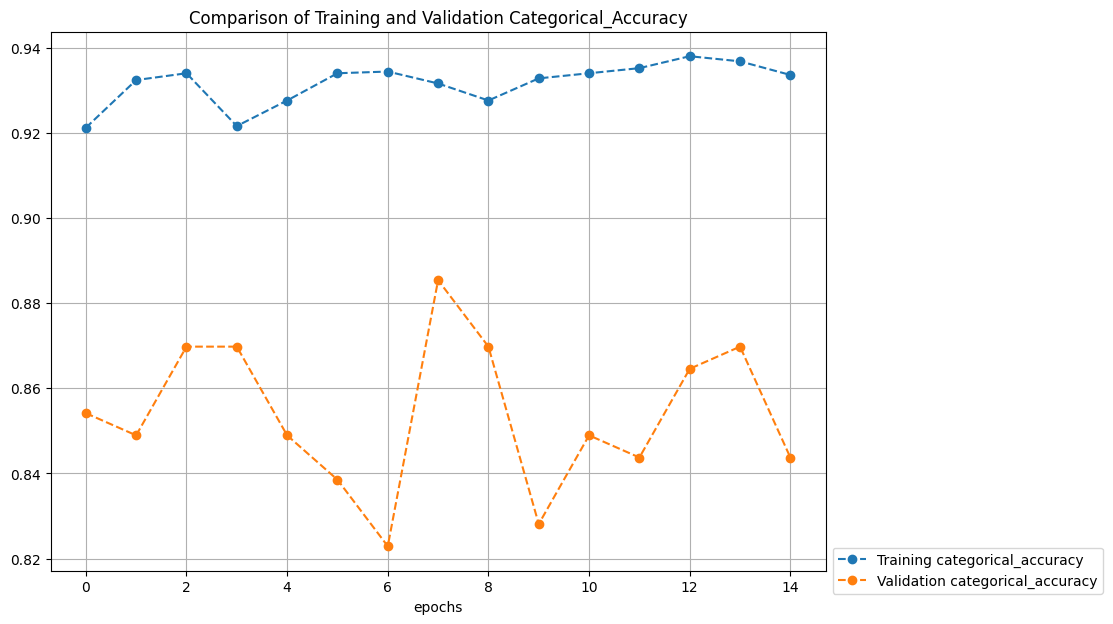

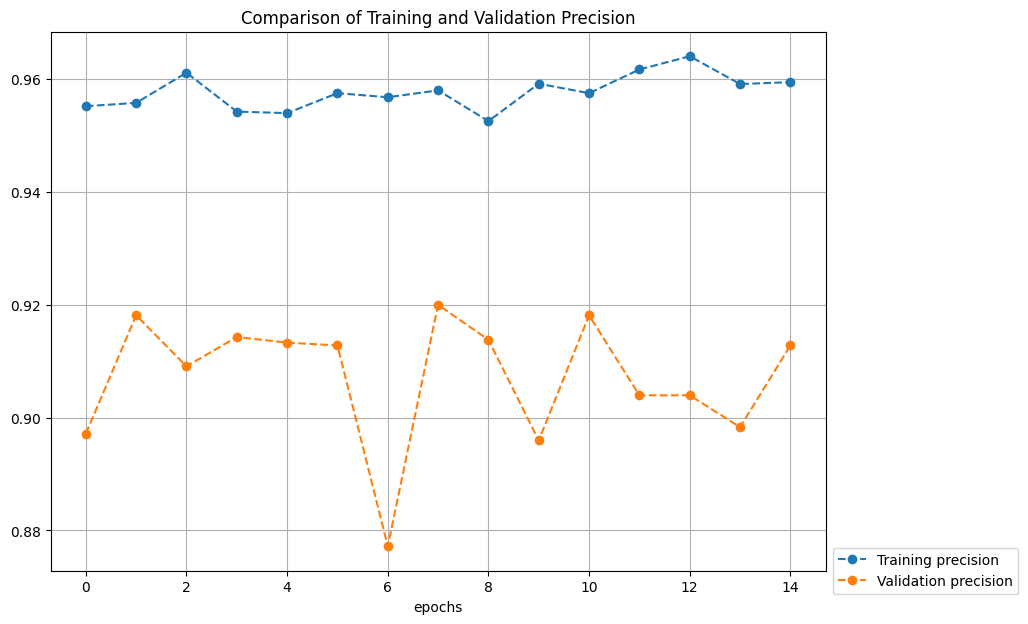

In [52]:
try:
  _helper.evaluation.history_plot(enb0_m4_a_h,
                                  "./saved_files/TL_FT/m4/A",
                                  specification = "comp_loss",
                                  grid = True,
                                  plot_style = "o--")

  _helper.evaluation.history_plot(enb0_m4_a_h,
                                  "./saved_files/TL_FT/m4/A",
                                  specification = "comp_categorical_accuracy",
                                  grid = True,
                                  plot_style = "o--")

  _helper.evaluation.history_plot(enb0_m4_a_h,
                                  "./saved_files/TL_FT/m4/A",
                                  specification = "comp_precision",
                                  grid = True,
                                  plot_style = "o--")

  _helper.save_load.save(enb0_m4_a, enb0_m4_a_h, "./saved_files/TL_FT/m4/A", "Model")
except Exception is e:
  print(f"Error: {e}")
  _helper.notifications.error()

#### Model 4 Custom

In [56]:
for layers in enb0.layers[:-10]:
  layers.trainable = False
  
for layer_number, layer in enumerate(enb0.layers):
  print(f"{layer.trainable} : {layer.name}")


False : input_2
False : rescaling_1
False : normalization_1
False : tf.math.truediv_1
False : stem_conv_pad
False : stem_conv
False : stem_bn
False : stem_activation
False : block1a_dwconv
False : block1a_bn
False : block1a_activation
False : block1a_se_squeeze
False : block1a_se_reshape
False : block1a_se_reduce
False : block1a_se_expand
False : block1a_se_excite
False : block1a_project_conv
False : block1a_project_bn
False : block2a_expand_conv
False : block2a_expand_bn
False : block2a_expand_activation
False : block2a_dwconv_pad
False : block2a_dwconv
False : block2a_bn
False : block2a_activation
False : block2a_se_squeeze
False : block2a_se_reshape
False : block2a_se_reduce
False : block2a_se_expand
False : block2a_se_excite
False : block2a_project_conv
False : block2a_project_bn
False : block2b_expand_conv
False : block2b_expand_bn
False : block2b_expand_activation
False : block2b_dwconv
False : block2b_bn
False : block2b_activation
False : block2b_se_squeeze
False : block2b_se_re

In [58]:
try:
  for layers in enb0.layers[:-10]:
    layers.trainable = True

  enb0_m4_b = enb0_m3_b

  enb0_m4_b._name = "ENB0_Model_4_b"

  enb0_m4_b.compile(
    loss = "categorical_crossentropy",
    optimizer = Adam(0.001),
    metrics = ["CategoricalAccuracy", "Precision"]
  )
  enb0_m4_b_h = enb0_m4_b.fit(train_data_10p,
                              epochs = 30,
                              steps_per_epoch = len(train_data_10p),
                              validation_data = test_data_10p,
                              validation_steps = len(test_data_10p),
                              initial_epoch = enb0_m3_b_h.epoch[-1],
                              callbacks = [_helper.callbacks.tensorboard_callback("./log/TLFT/m4/",
                                                                                    "B"),
                                          checkpoint])
  _helper.notifications.model_callback_notification()
except Exception as e:
  print(f"Error: {e}")
  _helper.notifications.error()

Saving TensorBoard Log Files to: ./log/TLFT/m4//B/2022_08_24 - 16_35_log
Epoch 15/30
79/79 [==============================] - 171s 2s/step - loss: 0.6345 - categorical_accuracy: 0.7944 - precision: 0.8516 - val_loss: 0.7885 - val_categorical_accuracy: 0.7867 - val_precision: 0.8162
Epoch 16/30
79/79 [==============================] - 132s 2s/step - loss: 0.4956 - categorical_accuracy: 0.8372 - precision: 0.8805 - val_loss: 0.6306 - val_categorical_accuracy: 0.8267 - val_precision: 0.8525
Epoch 17/30
79/79 [==============================] - 139s 2s/step - loss: 0.4677 - categorical_accuracy: 0.8444 - precision: 0.8799 - val_loss: 0.5646 - val_categorical_accuracy: 0.8467 - val_precision: 0.8775
Epoch 18/30
79/79 [==============================] - 136s 2s/step - loss: 0.3918 - categorical_accuracy: 0.8652 - precision: 0.9064 - val_loss: 0.6634 - val_categorical_accuracy: 0.8093 - val_precision: 0.8303
Epoch 19/30
79/79 [==============================] - 141s 2s/step - loss: 0.3235 - cate

Model is saved to ./saved_files/TL_FT/m4/Model B_2022_08_24 - 17.h5 and ./saved_files/TL_FT/m4/Model B_diagram.png
History is saved to ./saved_files/TL_FT/m4/Model B_2022_08_24 - 17_history.json


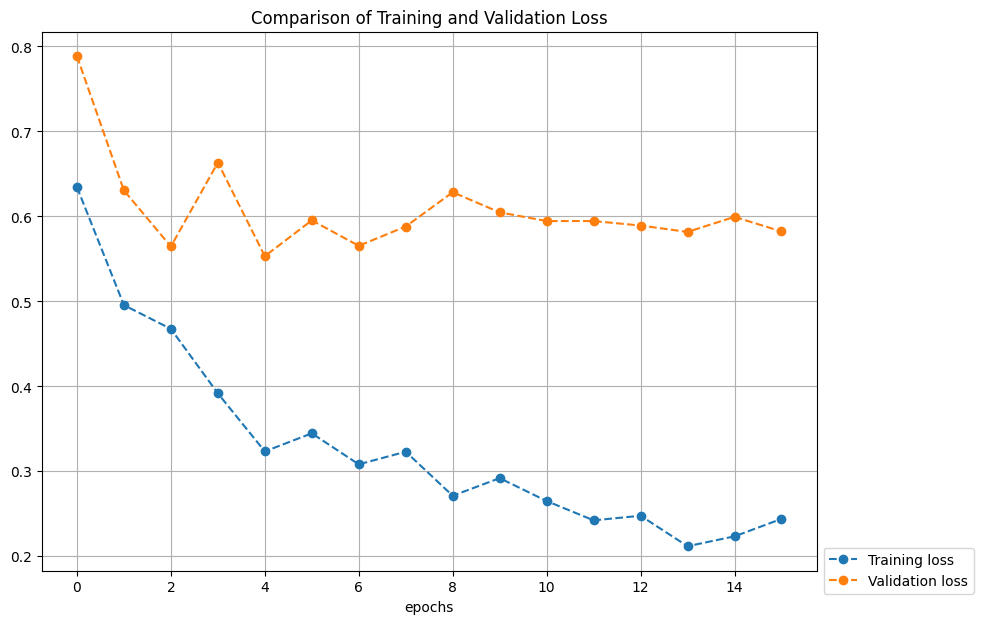

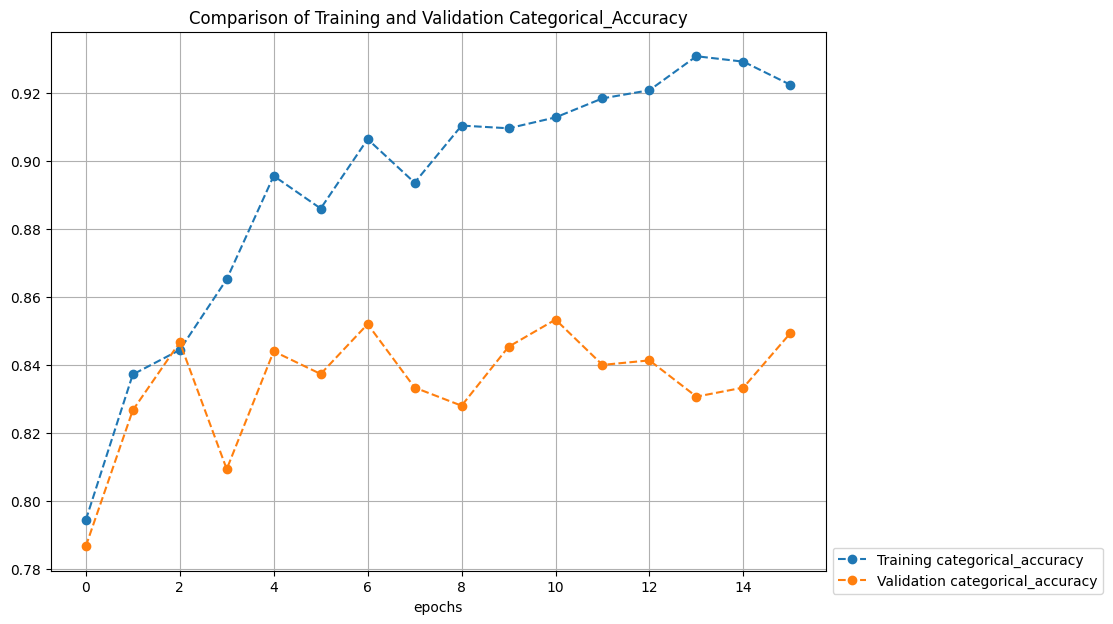

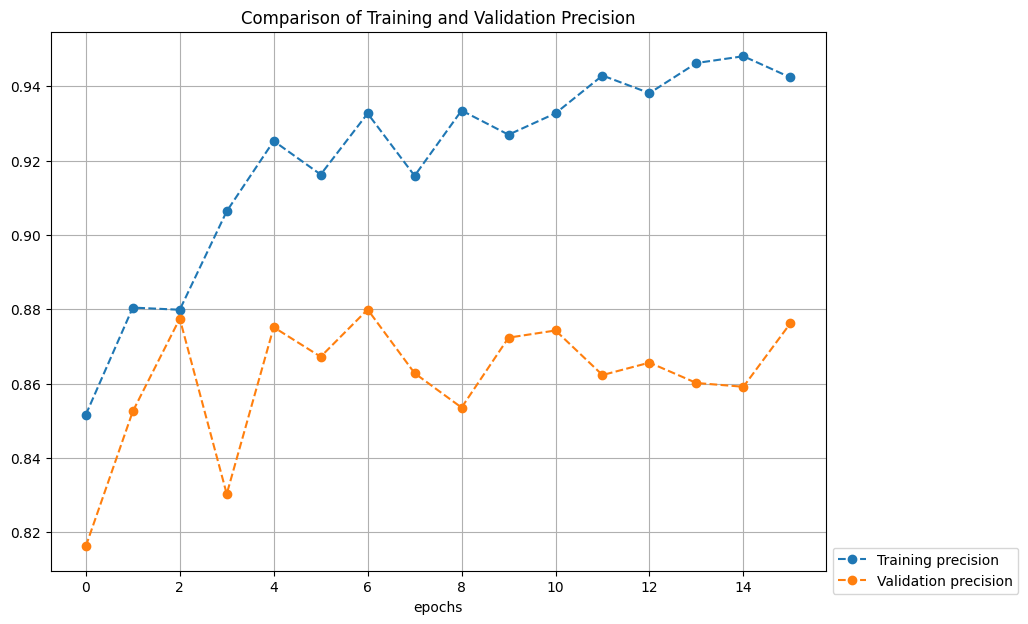

In [59]:
try:
  _helper.evaluation.history_plot(enb0_m4_b_h,
                                  "./saved_files/TL_FT/m4/B",
                                  specification = "comp_loss",
                                  grid = True,
                                  plot_style = "o--")

  _helper.evaluation.history_plot(enb0_m4_b_h,
                                  "./saved_files/TL_FT/m4/B",
                                  specification = "comp_categorical_accuracy",
                                  grid = True,
                                  plot_style = "o--")

  _helper.evaluation.history_plot(enb0_m4_b_h,
                                  "./saved_files/TL_FT/m4/B",
                                  specification = "comp_precision",
                                  grid = True,
                                  plot_style = "o--")

  _helper.save_load.save(enb0_m4_b, enb0_m4_b_h, "./saved_files/TL_FT/m4/", "Model B")
except Exception is e:
  print(f"Error: {e}")
  _helper.notifications.error()

### Model Visualization of Fine Tuning with Feature Extracted Model

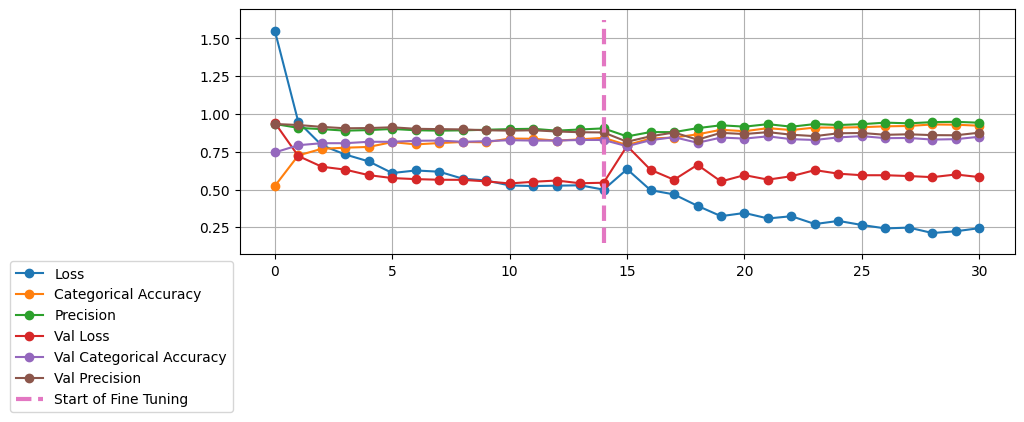

In [60]:
try:
  _helper.evaluation.feature_fine_tune_plot(enb0_m3_b_h, enb0_m4_b_h,
                                            grid = True,
                                            marker_style = "o")
except Exception as e:
  print(f"Error: {e}")
  _helper.notifications.error()

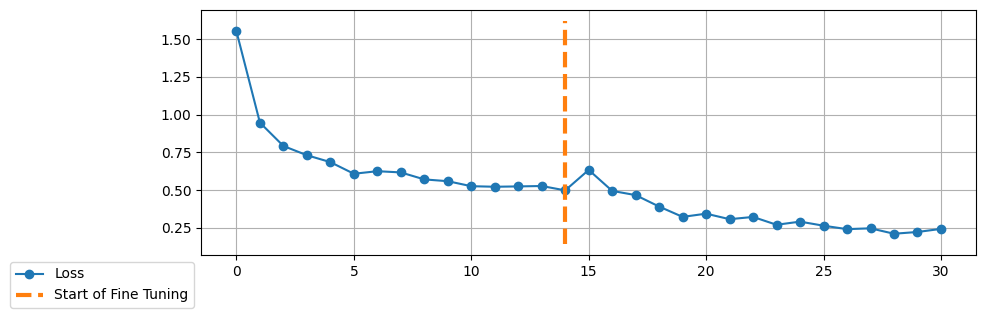

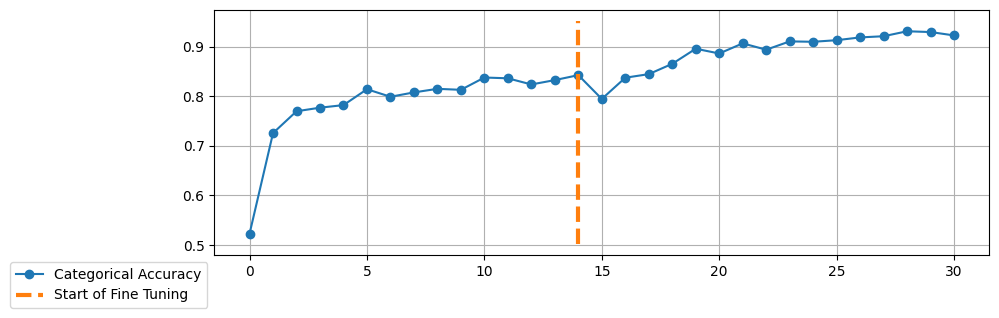

In [61]:
try:
  _helper.evaluation.feature_fine_tune_plot(enb0_m3_b_h, enb0_m4_b_h,
                                            specification = ["loss"],
                                            grid = True,
                                            marker_style = "o")
  
  _helper.evaluation.feature_fine_tune_plot(enb0_m3_b_h, enb0_m4_b_h,
                                            specification = ["categorical_accuracy"],
                                            grid = True,
                                            marker_style = "o")
except Exception as e:
  print(f"Error: {e}")
  _helper.notifications.error()

## Model 5
- Random 100% of Training data only
- Augmented Data
- Fine Tuning: Model 2, with top layer trained on custom data, top 10 layer will be unfrozen

In [ ]:
_helper.data_preparations.zip_processing("https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip",
                                         "10_food_classes_all_data")

In [64]:
train_data_100p, test_data_100p, CLASS_NAMES = _helper.data_preparations.train_test_dir_setter("./resources/10_food_classes_all_data",
                                                                        CLASS_MODE = "categorical")

Test Data: 
Found 2500 files belonging to 10 classes.
Train Data: 
Found 7500 files belonging to 10 classes.
Class Names: ['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']


#### Model 5 1:1

In [67]:
try:
  
  for layers in enb0.layers[:-10]:
    layers.trainable = False

  enb0_m5_a = enb0_m3_a

  enb0_m5_a._name = "ENB0_Model_5_A"

  enb0_m5_a.compile(
    loss = "categorical_crossentropy",
    optimizer = Adam(0.001),
    metrics = ["CategoricalAccuracy", "Precision"]
  )
  enb0_m5_a_h = enb0_m5_a.fit(train_data_100p,
                              epochs = 30,
                              steps_per_epoch = len(train_data_100p),
                              validation_data = test_data_100p,
                              validation_steps = int(0.25 * len(test_data_100p)),
                              callbacks = [_helper.callbacks.tensorboard_callback("./log/TLFT/m5/",
                                                                                    "A_m3"),
                                          checkpoint])
  _helper.notifications.model_callback_notification()
except Exception as e:
  print(f"Error: {e}")
  _helper.notifications.error()

Saving TensorBoard Log Files to: ./log/TLFT/m5//A_m3/2022_08_24 - 19_56_log
Epoch 1/30
79/79 [==============================] - 199s 2s/step - loss: 0.1250 - categorical_accuracy: 0.9664 - precision: 0.9743 - val_loss: 0.4795 - val_categorical_accuracy: 0.8475 - val_precision: 0.8777
Epoch 2/30
79/79 [==============================] - 172s 2s/step - loss: 0.1251 - categorical_accuracy: 0.9636 - precision: 0.9726 - val_loss: 0.5003 - val_categorical_accuracy: 0.8443 - val_precision: 0.8743
Epoch 3/30
79/79 [==============================] - 179s 2s/step - loss: 0.1145 - categorical_accuracy: 0.9708 - precision: 0.9772 - val_loss: 0.5076 - val_categorical_accuracy: 0.8394 - val_precision: 0.8681
Epoch 4/30
79/79 [==============================] - 186s 2s/step - loss: 0.1149 - categorical_accuracy: 0.9756 - precision: 0.9792 - val_loss: 0.4975 - val_categorical_accuracy: 0.8427 - val_precision: 0.8718
Epoch 5/30
79/79 [==============================] - 173s 2s/step - loss: 0.1105 - catego

Model is saved to ./saved_files/TL_FT/m5/A_m3/Model A_2022_08_24 - 21.h5 and ./saved_files/TL_FT/m5/A_m3/Model A_diagram.png
History is saved to ./saved_files/TL_FT/m5/A_m3/Model A_2022_08_24 - 21_history.json


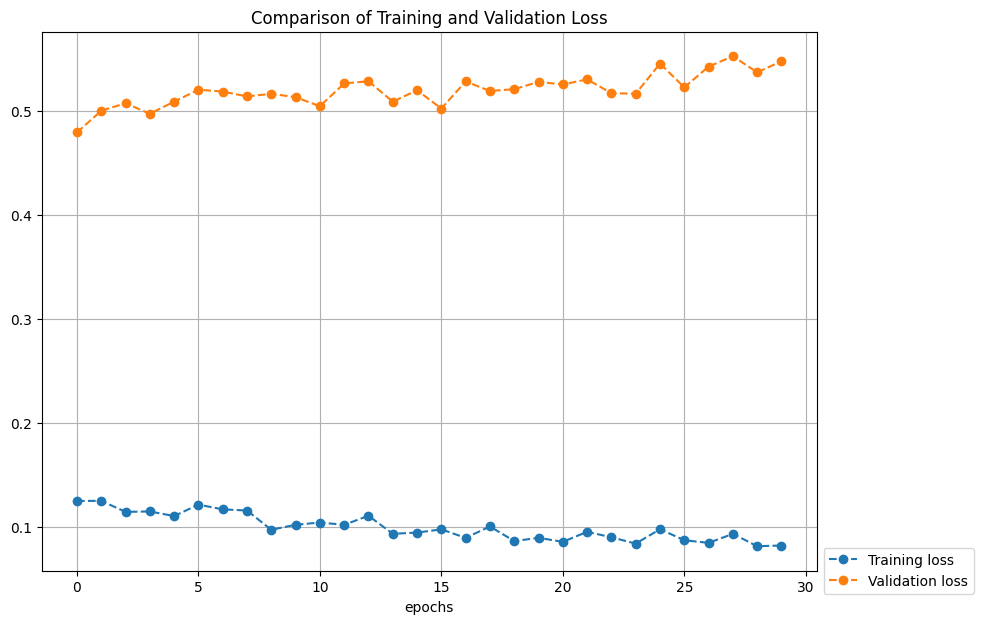

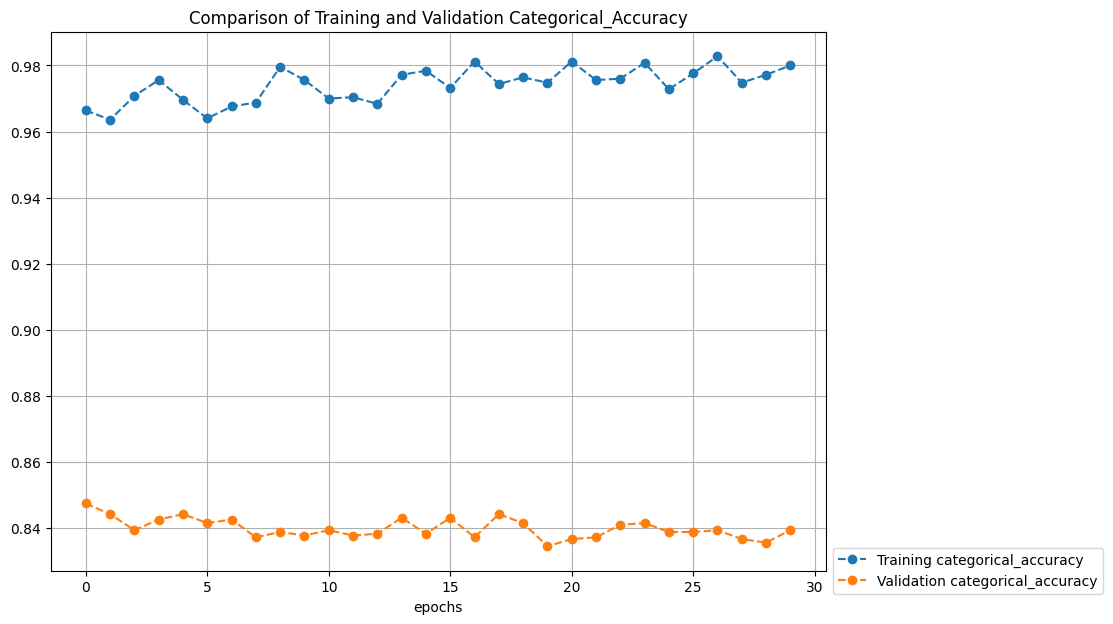

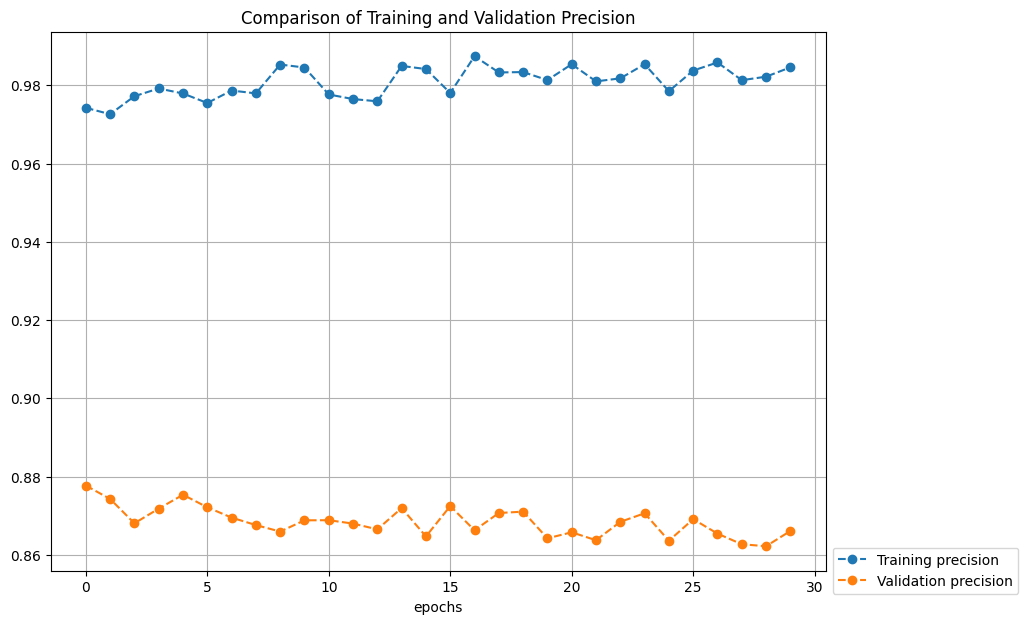

In [68]:
try:
  _helper.evaluation.history_plot(enb0_m5_a_h,
                                  "./saved_files/TL_FT/m5/A_m3",
                                  specification = "comp_loss",
                                  grid = True,
                                  plot_style = "o--")

  _helper.evaluation.history_plot(enb0_m5_a_h,
                                  "./saved_files/TL_FT/m5/A_m3",
                                  specification = "comp_categorical_accuracy",
                                  grid = True,
                                  plot_style = "o--")

  _helper.evaluation.history_plot(enb0_m5_a_h,
                                  "./saved_files/TL_FT/m5/A_m3",
                                  specification = "comp_precision",
                                  grid = True,
                                  plot_style = "o--")

  _helper.save_load.save(enb0_m5_a, enb0_m5_a_h, "./saved_files/TL_FT/m5/A_m3", "Model A")
except Exception is e:
  print(f"Error: {e}")
  _helper.notifications.error()



#### Model 5 Custom

In [69]:
try:
  
  for layers in enb0.layers[:-10]:
    layers.trainable = False

  enb0_m5_b = enb0_m3_b

  enb0_m5_b._name = "ENB0_Model_5_B"

  enb0_m5_b.compile(
    loss = "categorical_crossentropy",
    optimizer = Adam(0.001),
    metrics = ["CategoricalAccuracy", "Precision"]
  )
  enb0_m5_b_h = enb0_m5_b.fit(train_data_100p,
                              epochs = 30,
                              steps_per_epoch = len(train_data_100p),
                              validation_data = test_data_100p,
                              validation_steps = int(0.25 * len(test_data_100p)),
                              callbacks = [_helper.callbacks.tensorboard_callback("./log/TLFT/m5/",
                                                                                    "B_m3"),
                                          checkpoint])
  _helper.notifications.model_callback_notification()
except Exception as e:
  print(f"Error: {e}")
  _helper.notifications.error()

Saving TensorBoard Log Files to: ./log/TLFT/m5//B_m3/2022_08_24 - 21_52_log
Epoch 1/30
79/79 [==============================] - 200s 2s/step - loss: 0.2446 - categorical_accuracy: 0.9156 - precision: 0.9338 - val_loss: 0.6261 - val_categorical_accuracy: 0.8357 - val_precision: 0.8518
Epoch 2/30
79/79 [==============================] - 178s 2s/step - loss: 0.1903 - categorical_accuracy: 0.9332 - precision: 0.9475 - val_loss: 0.6274 - val_categorical_accuracy: 0.8497 - val_precision: 0.8643
Epoch 3/30
79/79 [==============================] - 196s 2s/step - loss: 0.2103 - categorical_accuracy: 0.9300 - precision: 0.9425 - val_loss: 0.6176 - val_categorical_accuracy: 0.8529 - val_precision: 0.8689
Epoch 4/30
79/79 [==============================] - 187s 2s/step - loss: 0.2067 - categorical_accuracy: 0.9336 - precision: 0.9478 - val_loss: 0.5807 - val_categorical_accuracy: 0.8567 - val_precision: 0.8799
Epoch 5/30
79/79 [==============================] - 177s 2s/step - loss: 0.1915 - catego

Model is saved to ./saved_files/TL_FT/m5/B_m3/Model_2022_08_24 - 23.h5 and ./saved_files/TL_FT/m5/B_m3/Model_diagram.png
History is saved to ./saved_files/TL_FT/m5/B_m3/Model_2022_08_24 - 23_history.json


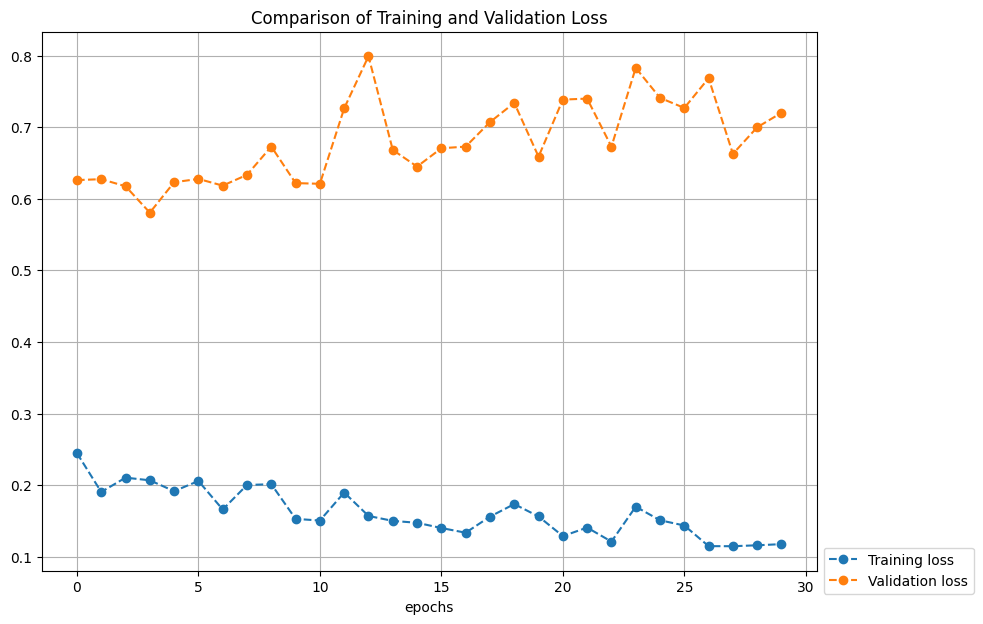

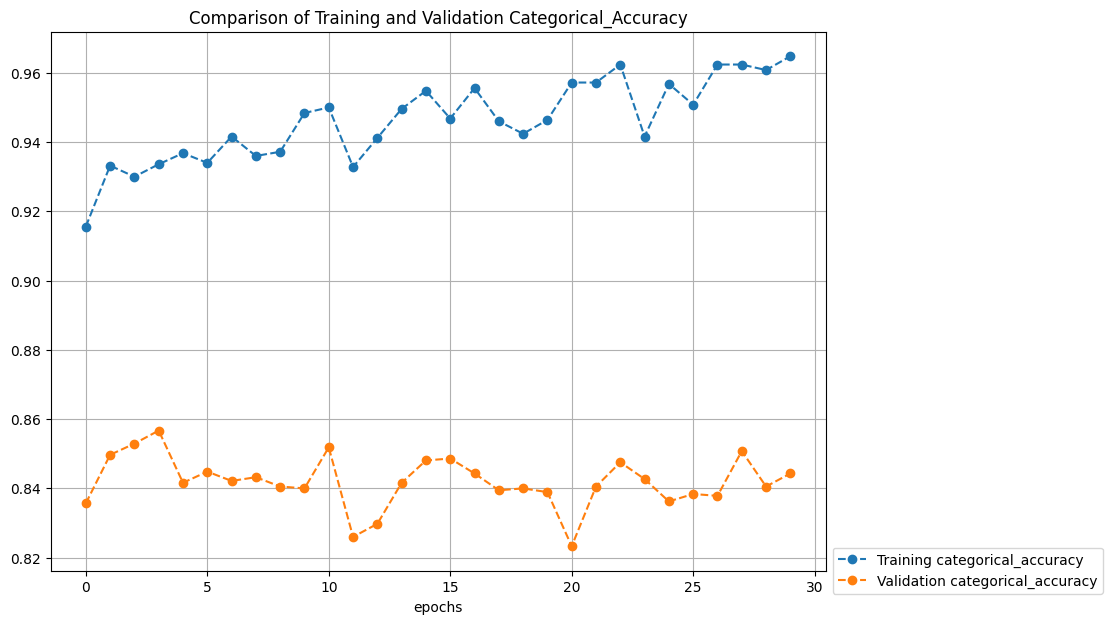

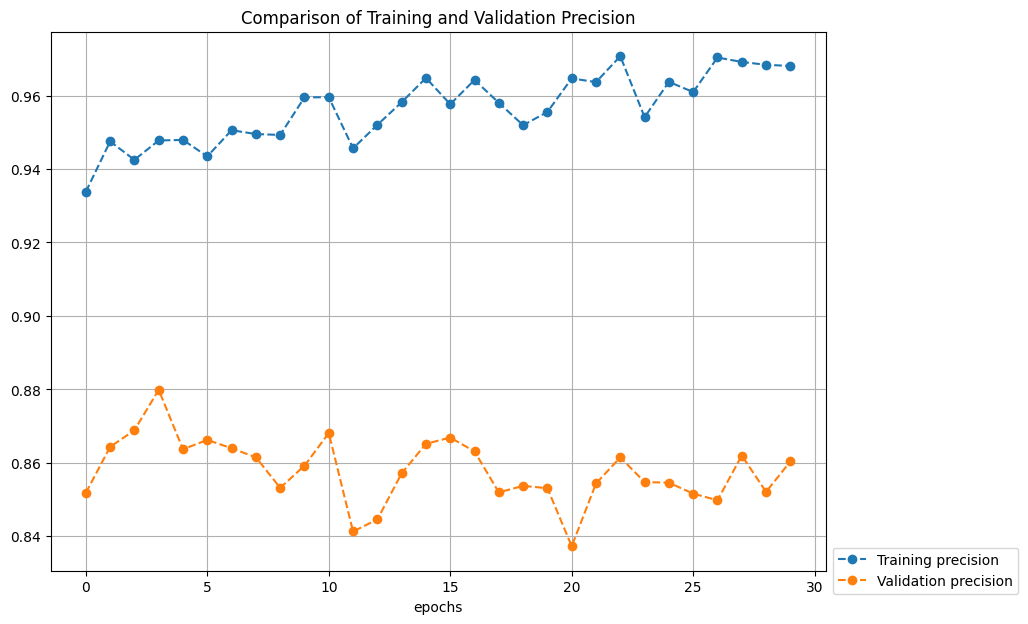

In [70]:
try:
  _helper.evaluation.history_plot(enb0_m5_b_h,
                                  "./saved_files/TL_FT/m5/B_m3",
                                  specification = "comp_loss",
                                  grid = True,
                                  plot_style = "o--")

  _helper.evaluation.history_plot(enb0_m5_b_h,
                                  "./saved_files/TL_FT/m5/B_m3",
                                  specification = "comp_categorical_accuracy",
                                  grid = True,
                                  plot_style = "o--")

  _helper.evaluation.history_plot(enb0_m5_b_h,
                                  "./saved_files/TL_FT/m5/B_m3",
                                  specification = "comp_precision",
                                  grid = True,
                                  plot_style = "o--")

  _helper.save_load.save(enb0_m5_b, enb0_m5_b_h, "./saved_files/TL_FT/m5/B_m3", "Model")
except Exception is e:
  print(f"Error: {e}")
  _helper.notifications.error()



# Sequential API vs Functional API

- Functional API Better
- Sequential API Used for Beginners

## Sequential API

In [ ]:
sequential_model = Sequential([
  Flatten(name = "Flatten"),
  Dense(64, activation = "relu", name = "Dense_Layer_1"),
  Dense(64, activation = "relu", name = "Dense_Layer_2"),
  Dense(10, activation = "softmax", name = "Output")
], name = "Sequential_Model")

sequential_model.compile(
  loss = 'SparseCategoricalCrossentropy',
  optimizer = Adam(),
  metrics = ['accuracy']
)

sequential_model.fit(x_train, y_train,
                     batch_size = BATCH_SIZE,
                     epocs = 5)

## Functional API

In [ ]:
input = Input(shape = (28, 28))
x = Flatten(name = "Flatten")(input)
x = Dense(64, activation = "relu", name = "Dense_1")(x)
x = Dense(64, activation = "relu", name = "Dense_2")(x)
output = Dense(64, activation = "softmax", name = "Output")(x)
functional_model = Model(input, output, name = "Functional_Model")

sequential_model.compile(
  loss = 'SparseCategoricalCrossentropy',
  optimizer = Adam(),
  metrics = ['accuracy']
)

sequential_model.fit(x_train, y_train,
                     batch_size = BATCH_SIZE,
                     epocs = 5)